# Проект: классификация

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [262]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [263]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [264]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [265]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

### Задание 3

In [266]:
df['balance'] = df['balance'].replace({'\$':''}, regex = True)
df['balance'] = df['balance'].replace({',':'.'}, regex = True)
df['balance'] = df['balance'].replace({' ':''}, regex = True)

In [267]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.00,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.00,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.00,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.00,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.00,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [268]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

df['balance']= df['balance'].apply(lambda x: float(x))

In [269]:
df['balance'].mean()

1529.1290293615875

### Задание 4

In [270]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())


In [271]:
df['balance'].mean()

1526.9360329690019

### Задание 5

In [272]:
df['education'].mode()

0    secondary
Name: education, dtype: object

In [273]:
df['job'].mode()

0    management
Name: job, dtype: object

In [274]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

In [275]:
df.groupby(['education', 'job']).agg({'balance': ['mean']})


balance
                                mean
education job                       
primary   admin.          775.928571
          blue-collar    1304.818444
          entrepreneur   1314.707317
          housemaid      1366.444444
          management     1841.534247
          retired        2222.631769
          self-employed  1254.928571
          services       1383.554217
          student        1492.047619
          technician     1805.975610
          unemployed     1607.392857
secondary admin.         1189.494662
          blue-collar    1125.866889
          entrepreneur   1304.445161
          housemaid      1018.229885
          management     1598.882979
          retired        2594.966759
          self-employed  1373.517007
          services       1028.724269
          student        1333.574219
          technician     1461.055511
          unemployed     1147.082949
tertiary  admin.         1343.482143
          blue-collar    1730.062500
          entrepreneur   2090.189394
          housemaid      2069.162791
          management     1826.104710
          retired        2314.992857
          self-employed  2254.047826
          services       1279.754717
          student        2018.722892
          technician     1766.792706
          unemployed     1552.666667

### Задание 6

In [276]:
def outliers_iqr(data, feature,log_scale=True):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    x = data[feature]
    quartile_1, quartile_3 = np.percentile(x,25), np.percentile(x,75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [277]:
outliers, cleaned = outliers_iqr(df, 'balance')
display(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')

'Число выбросов по методу Тьюки: 1057'

'Результирующее число записей: 10105'

## Часть 2:  Разведывательный анализ

### Задание 1

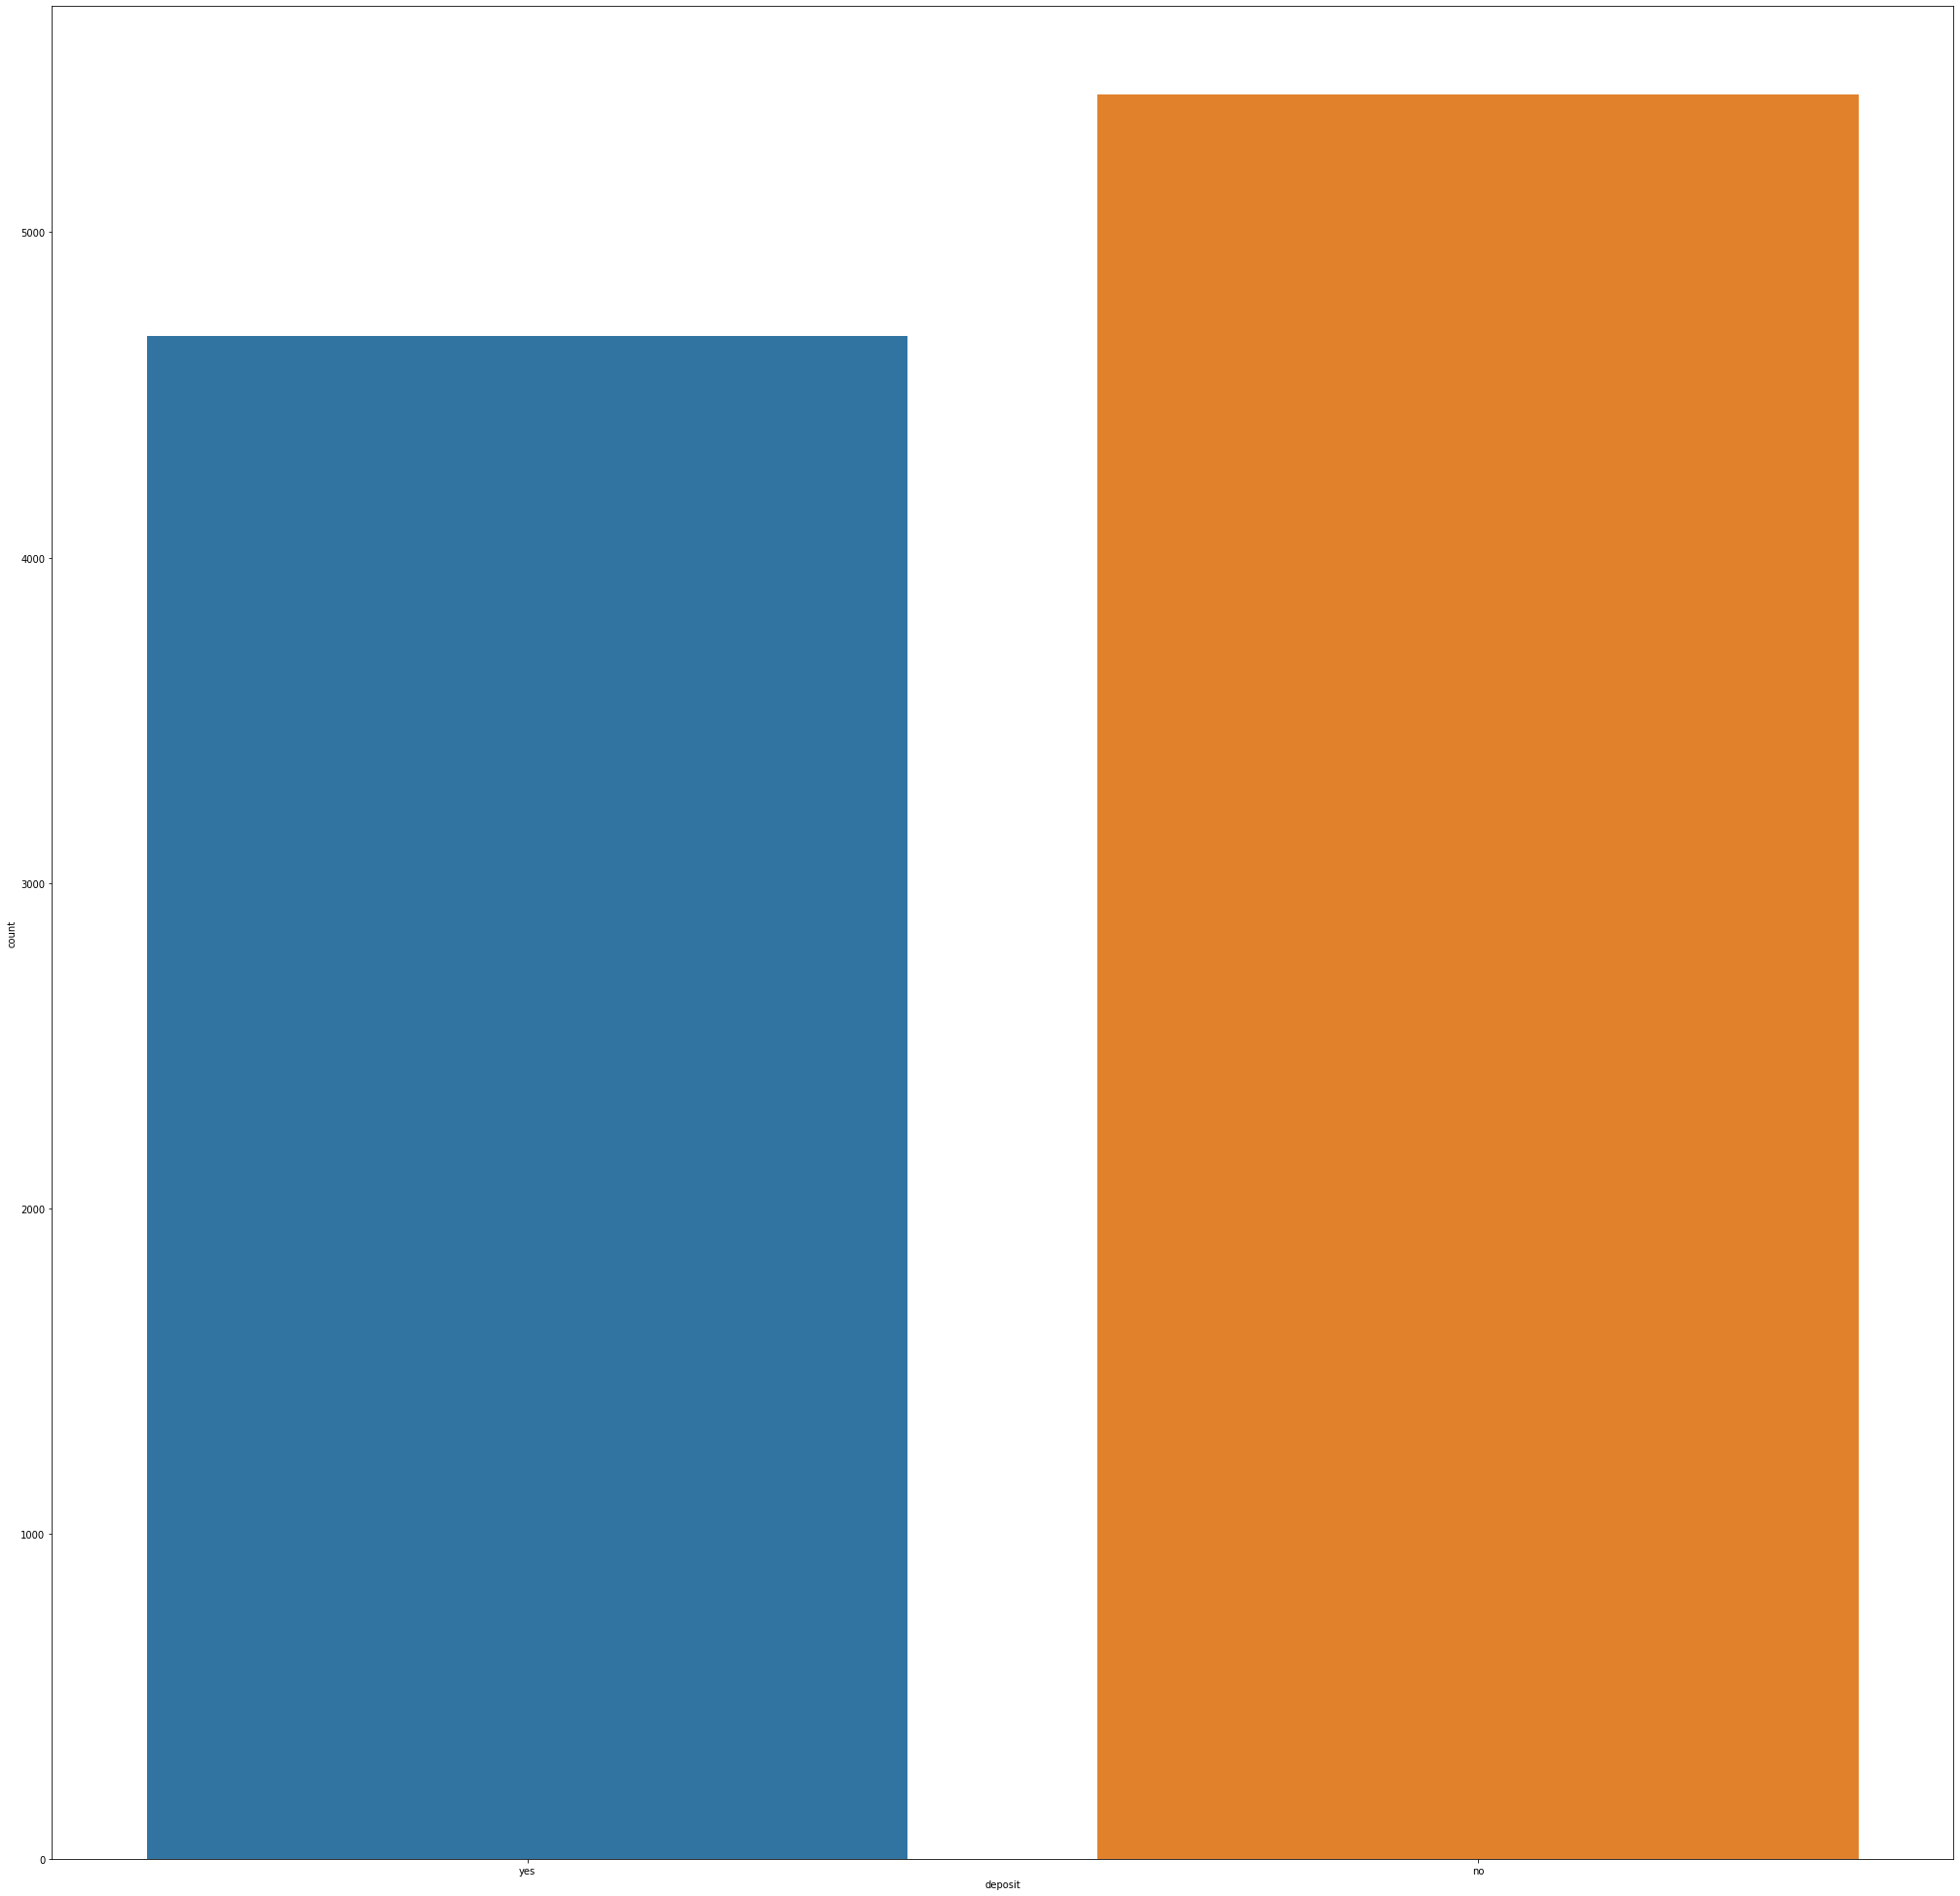

In [278]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=cleaned, x='deposit');

In [279]:
cleaned['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [280]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [281]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned['age'].max()

95

In [282]:
cleaned['duration'].min()

2

In [283]:
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'deposit']

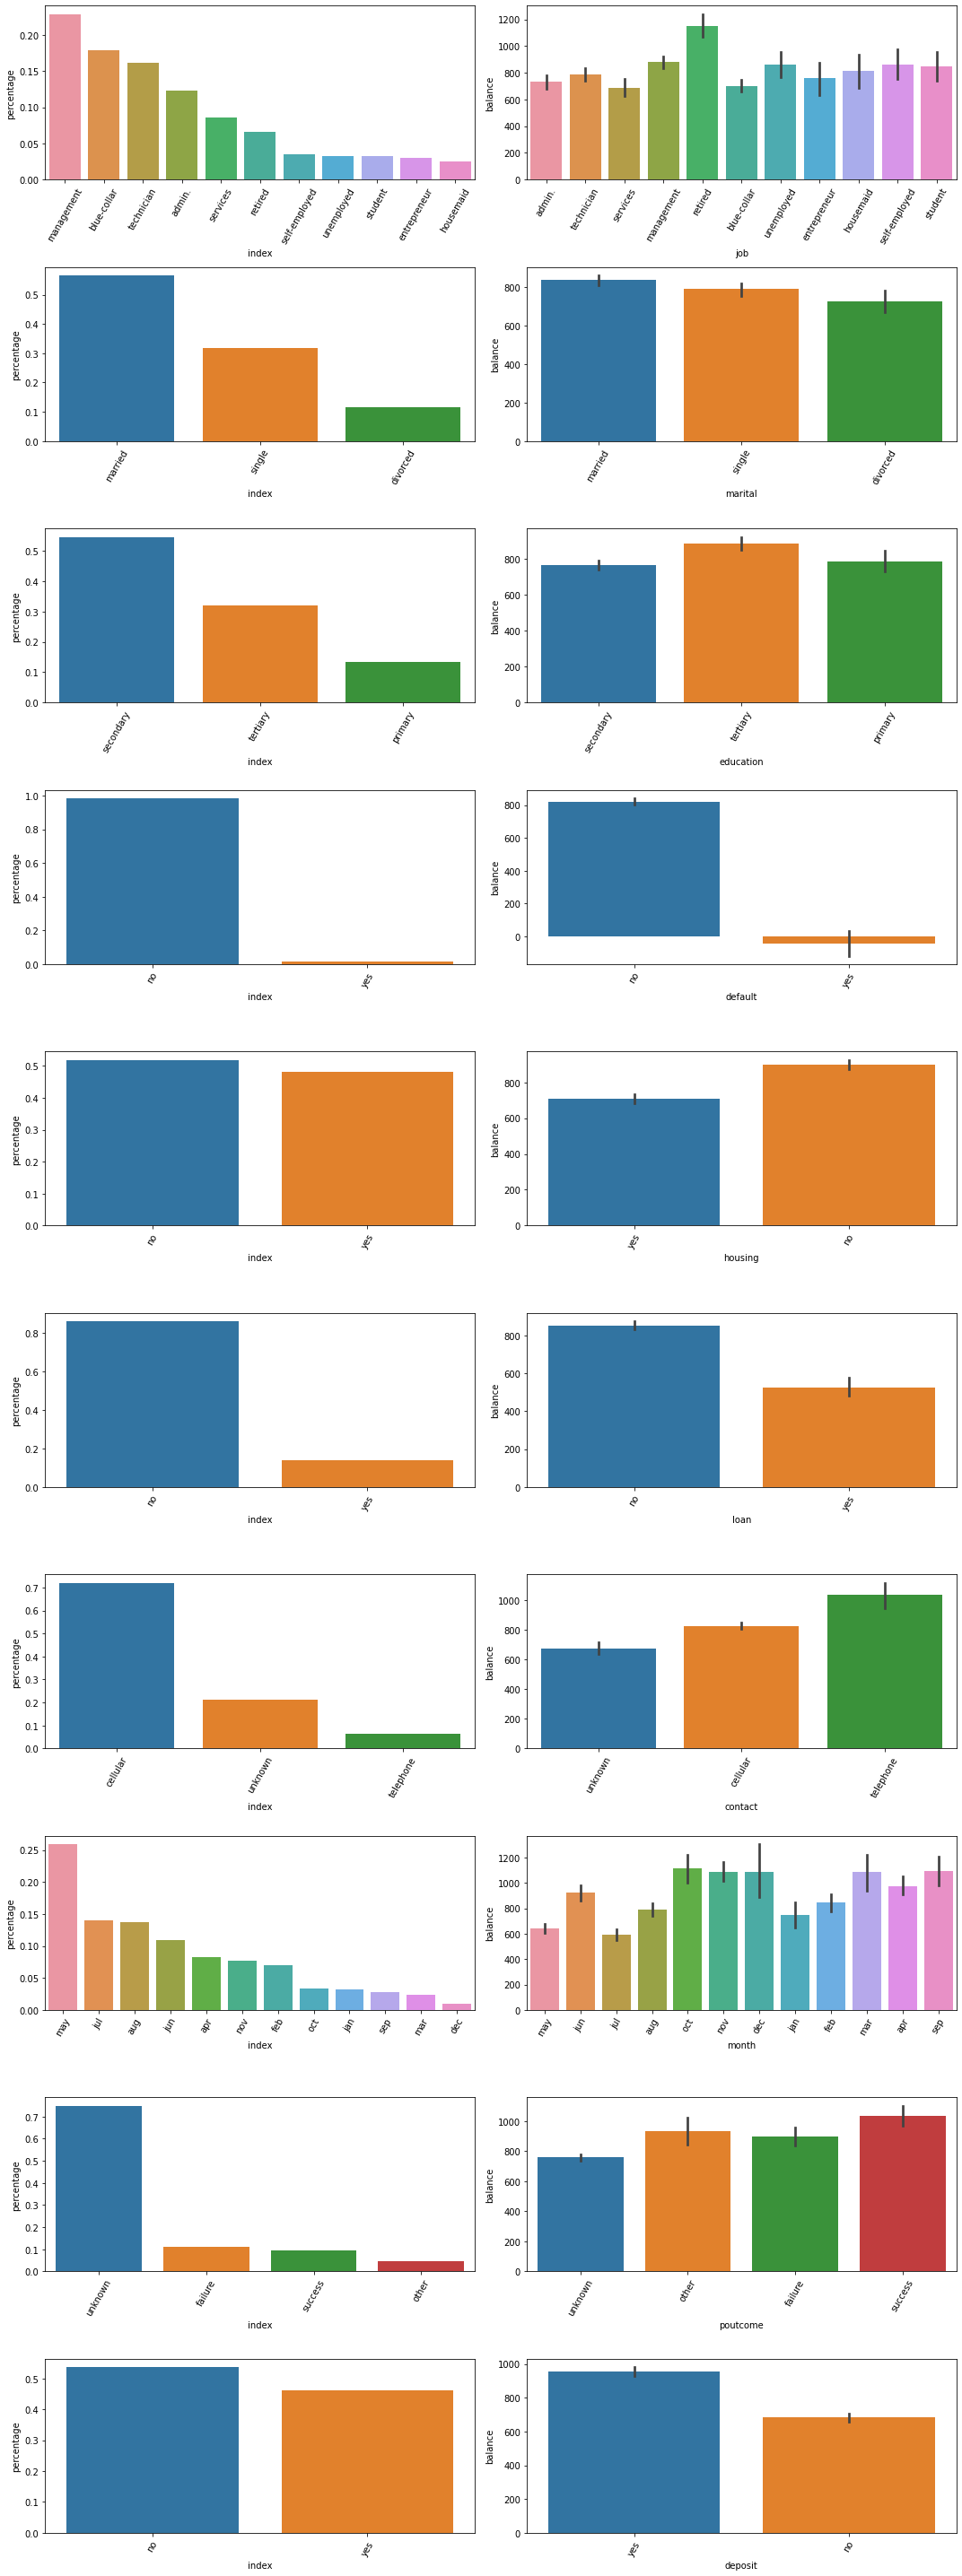

In [284]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=cleaned, x=feature, y='balance', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задания 4 и 5

### Задание 6

<AxesSubplot: xlabel='poutcome'>

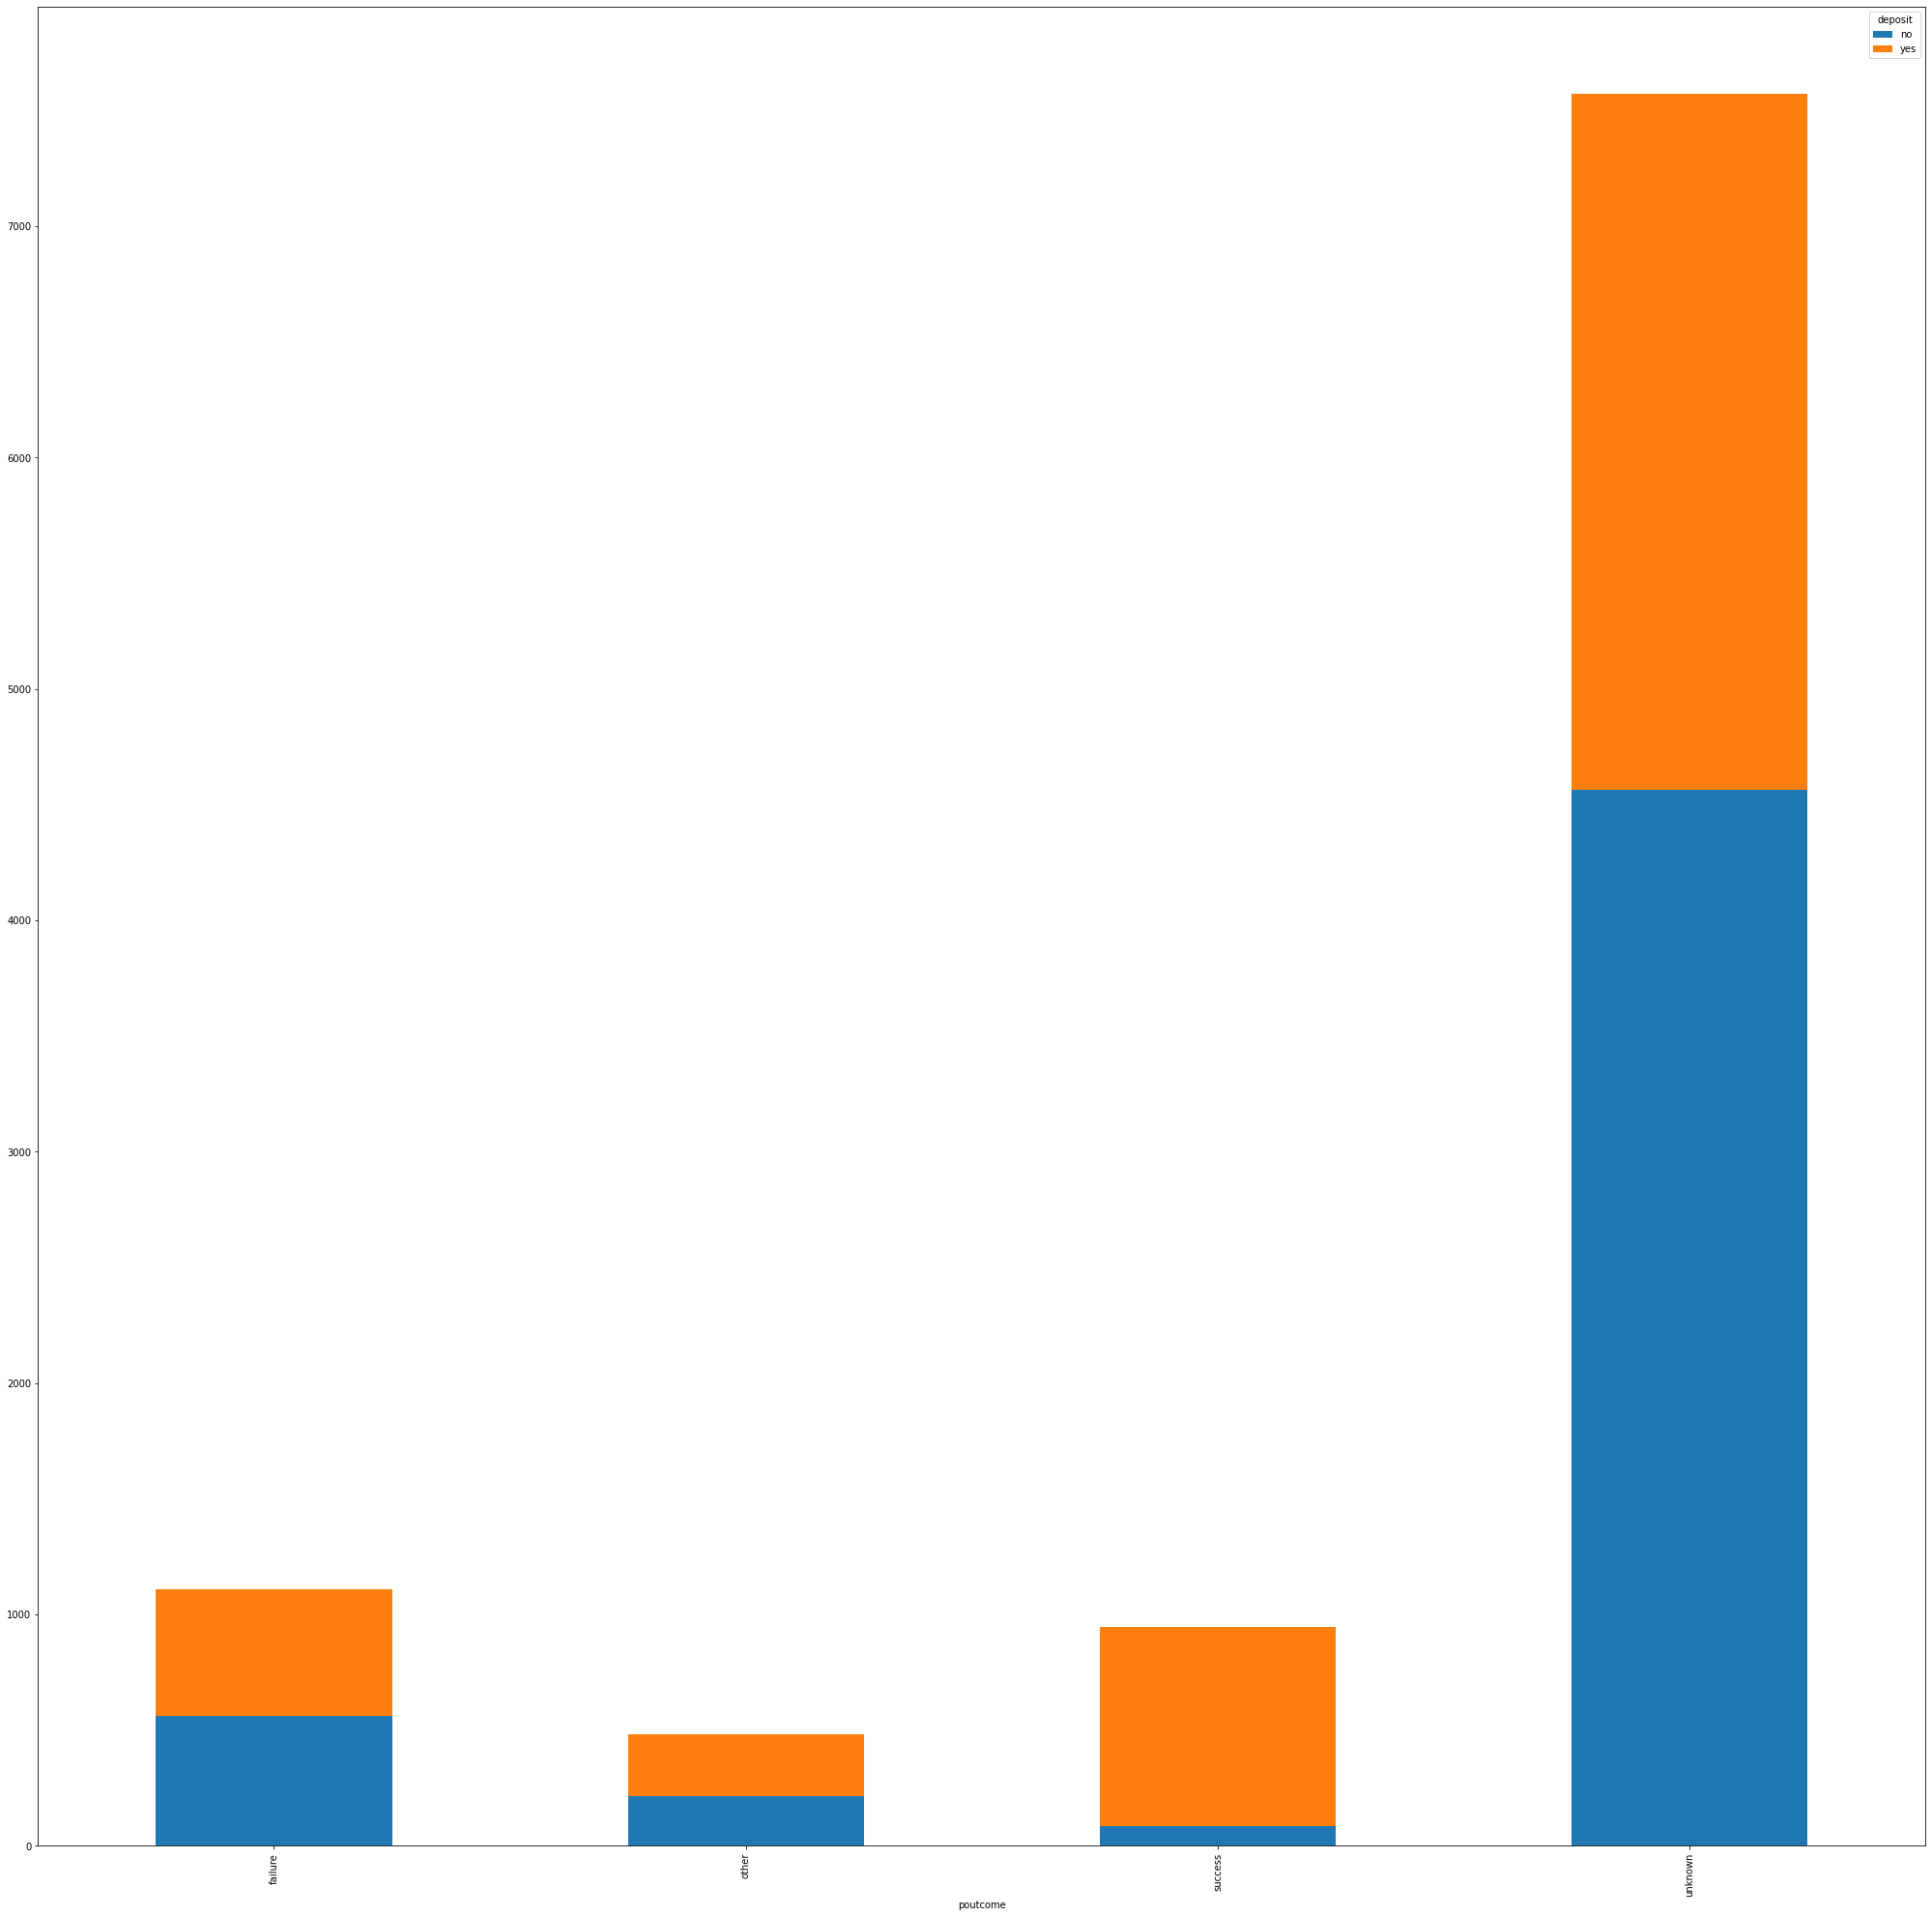

In [285]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = cleaned.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

<AxesSubplot: xlabel='month'>

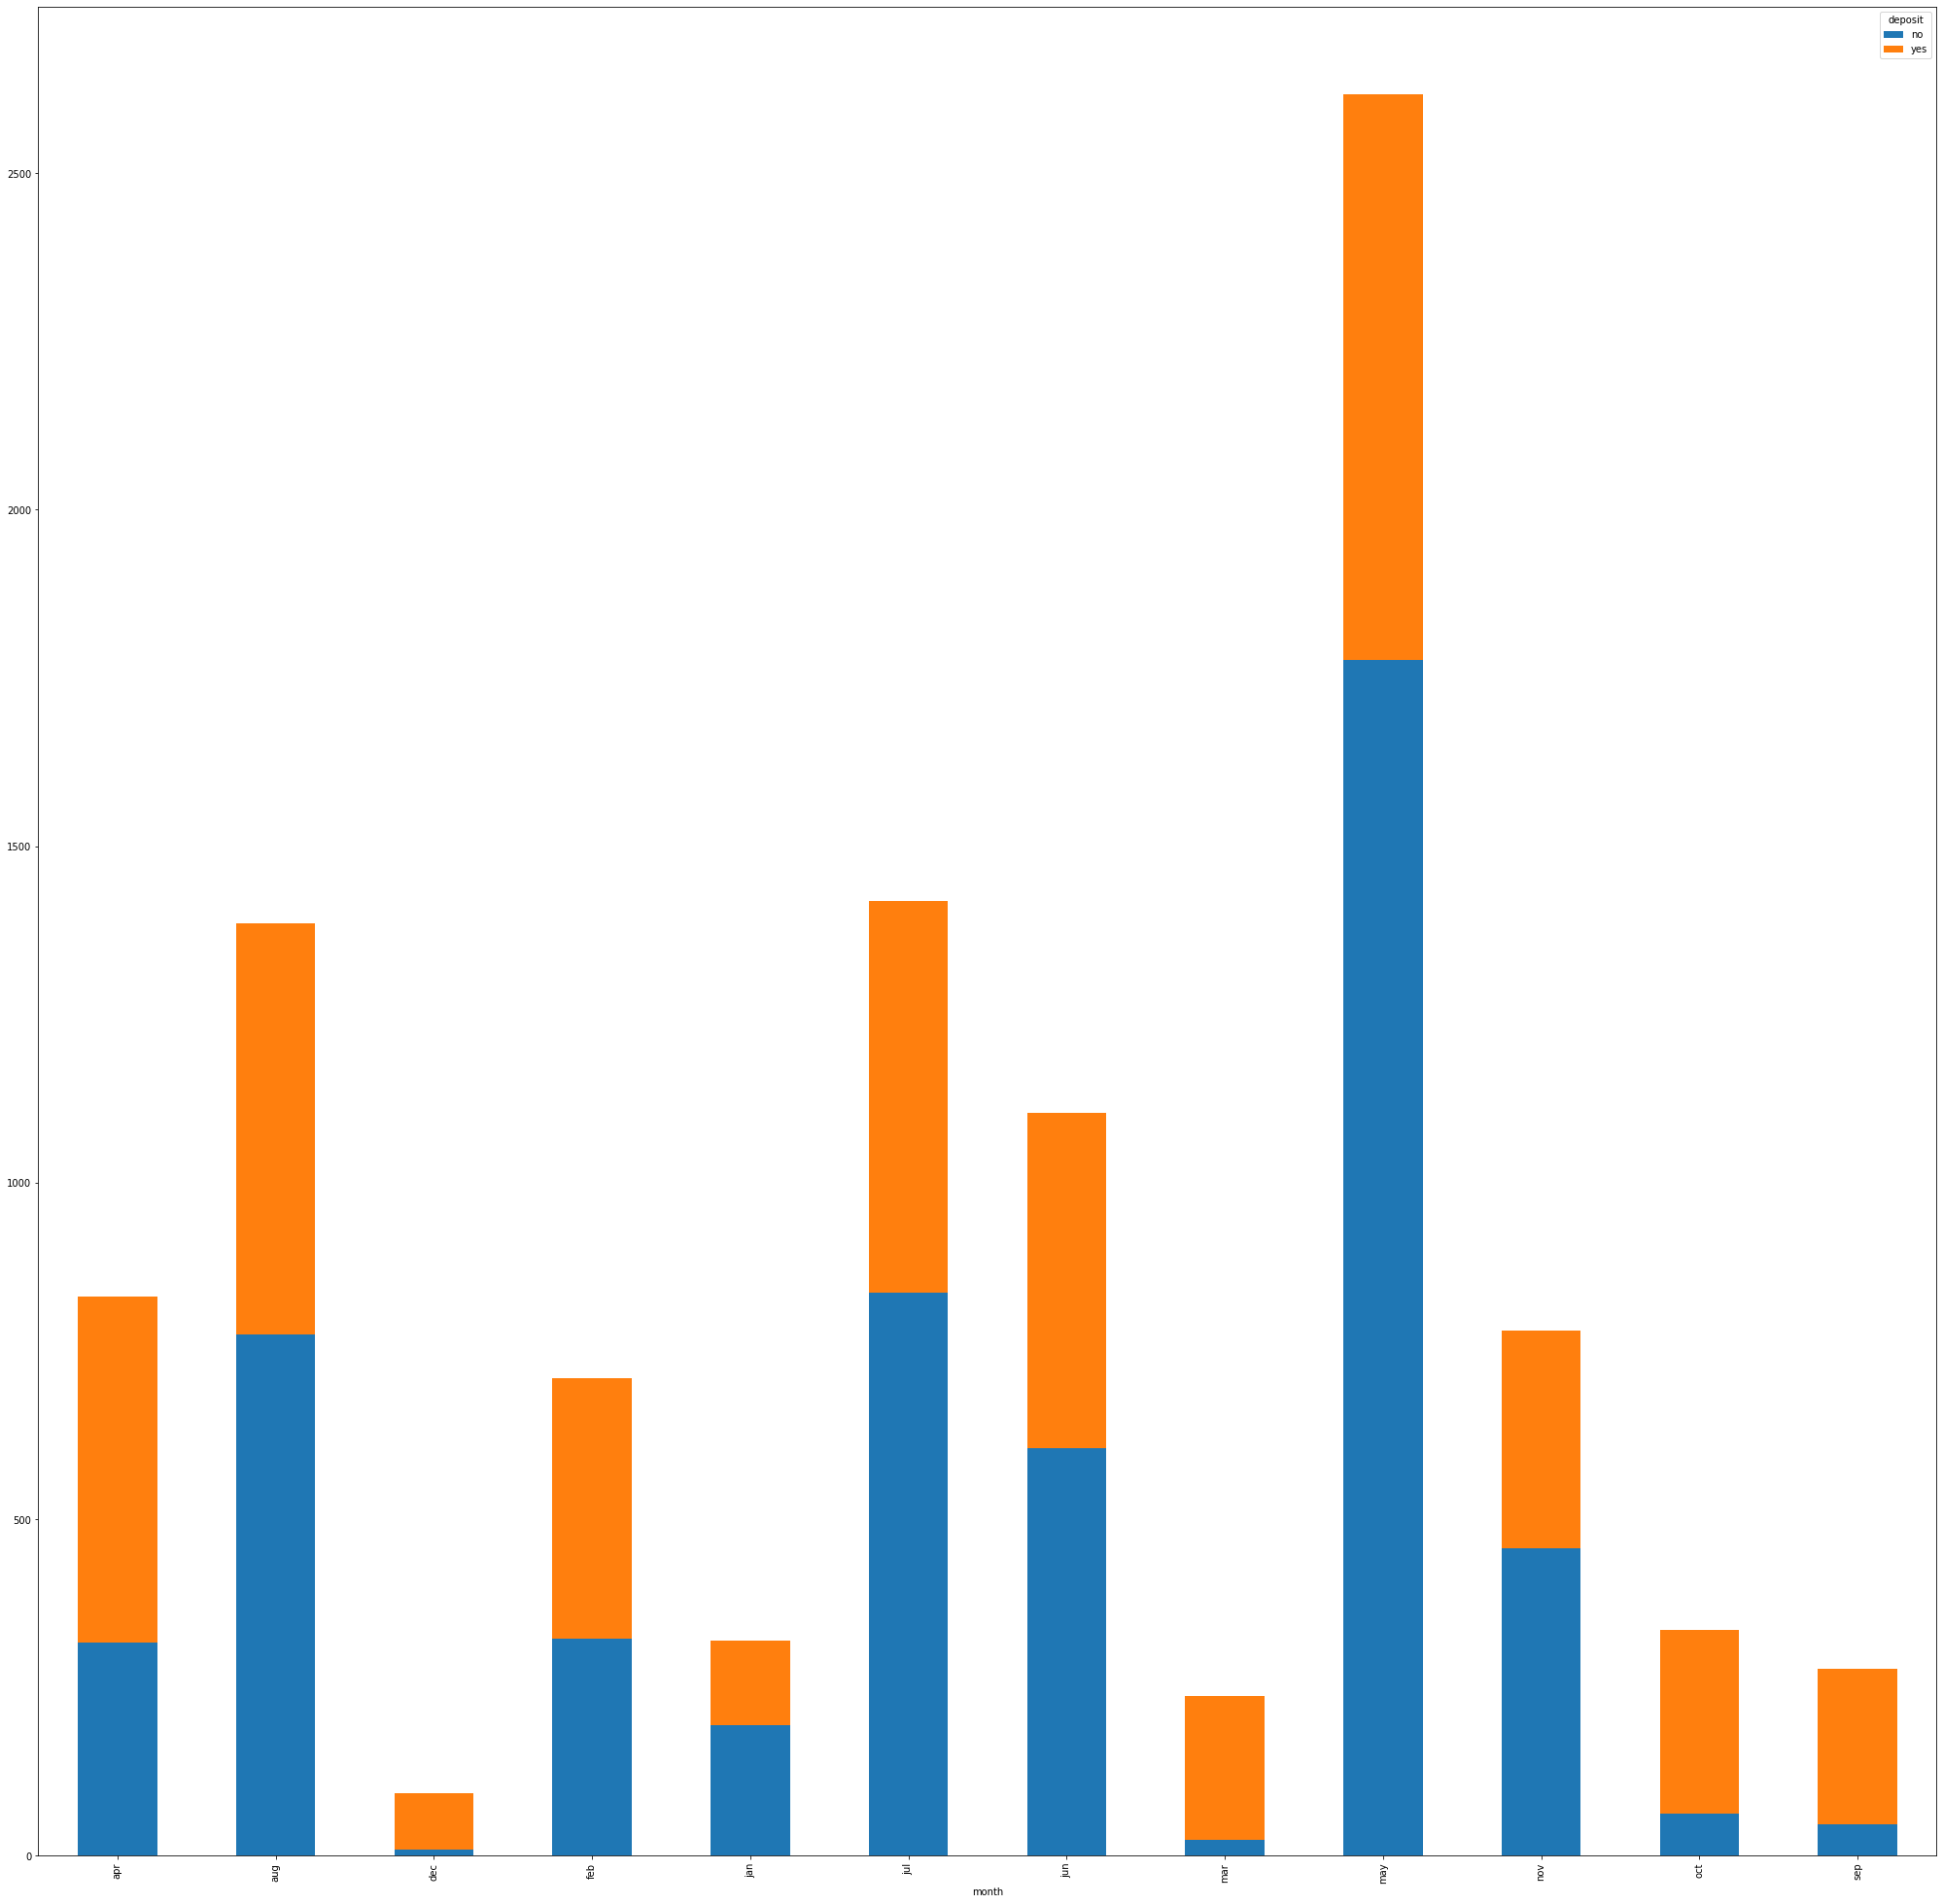

In [286]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
types = cleaned.groupby('month')['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

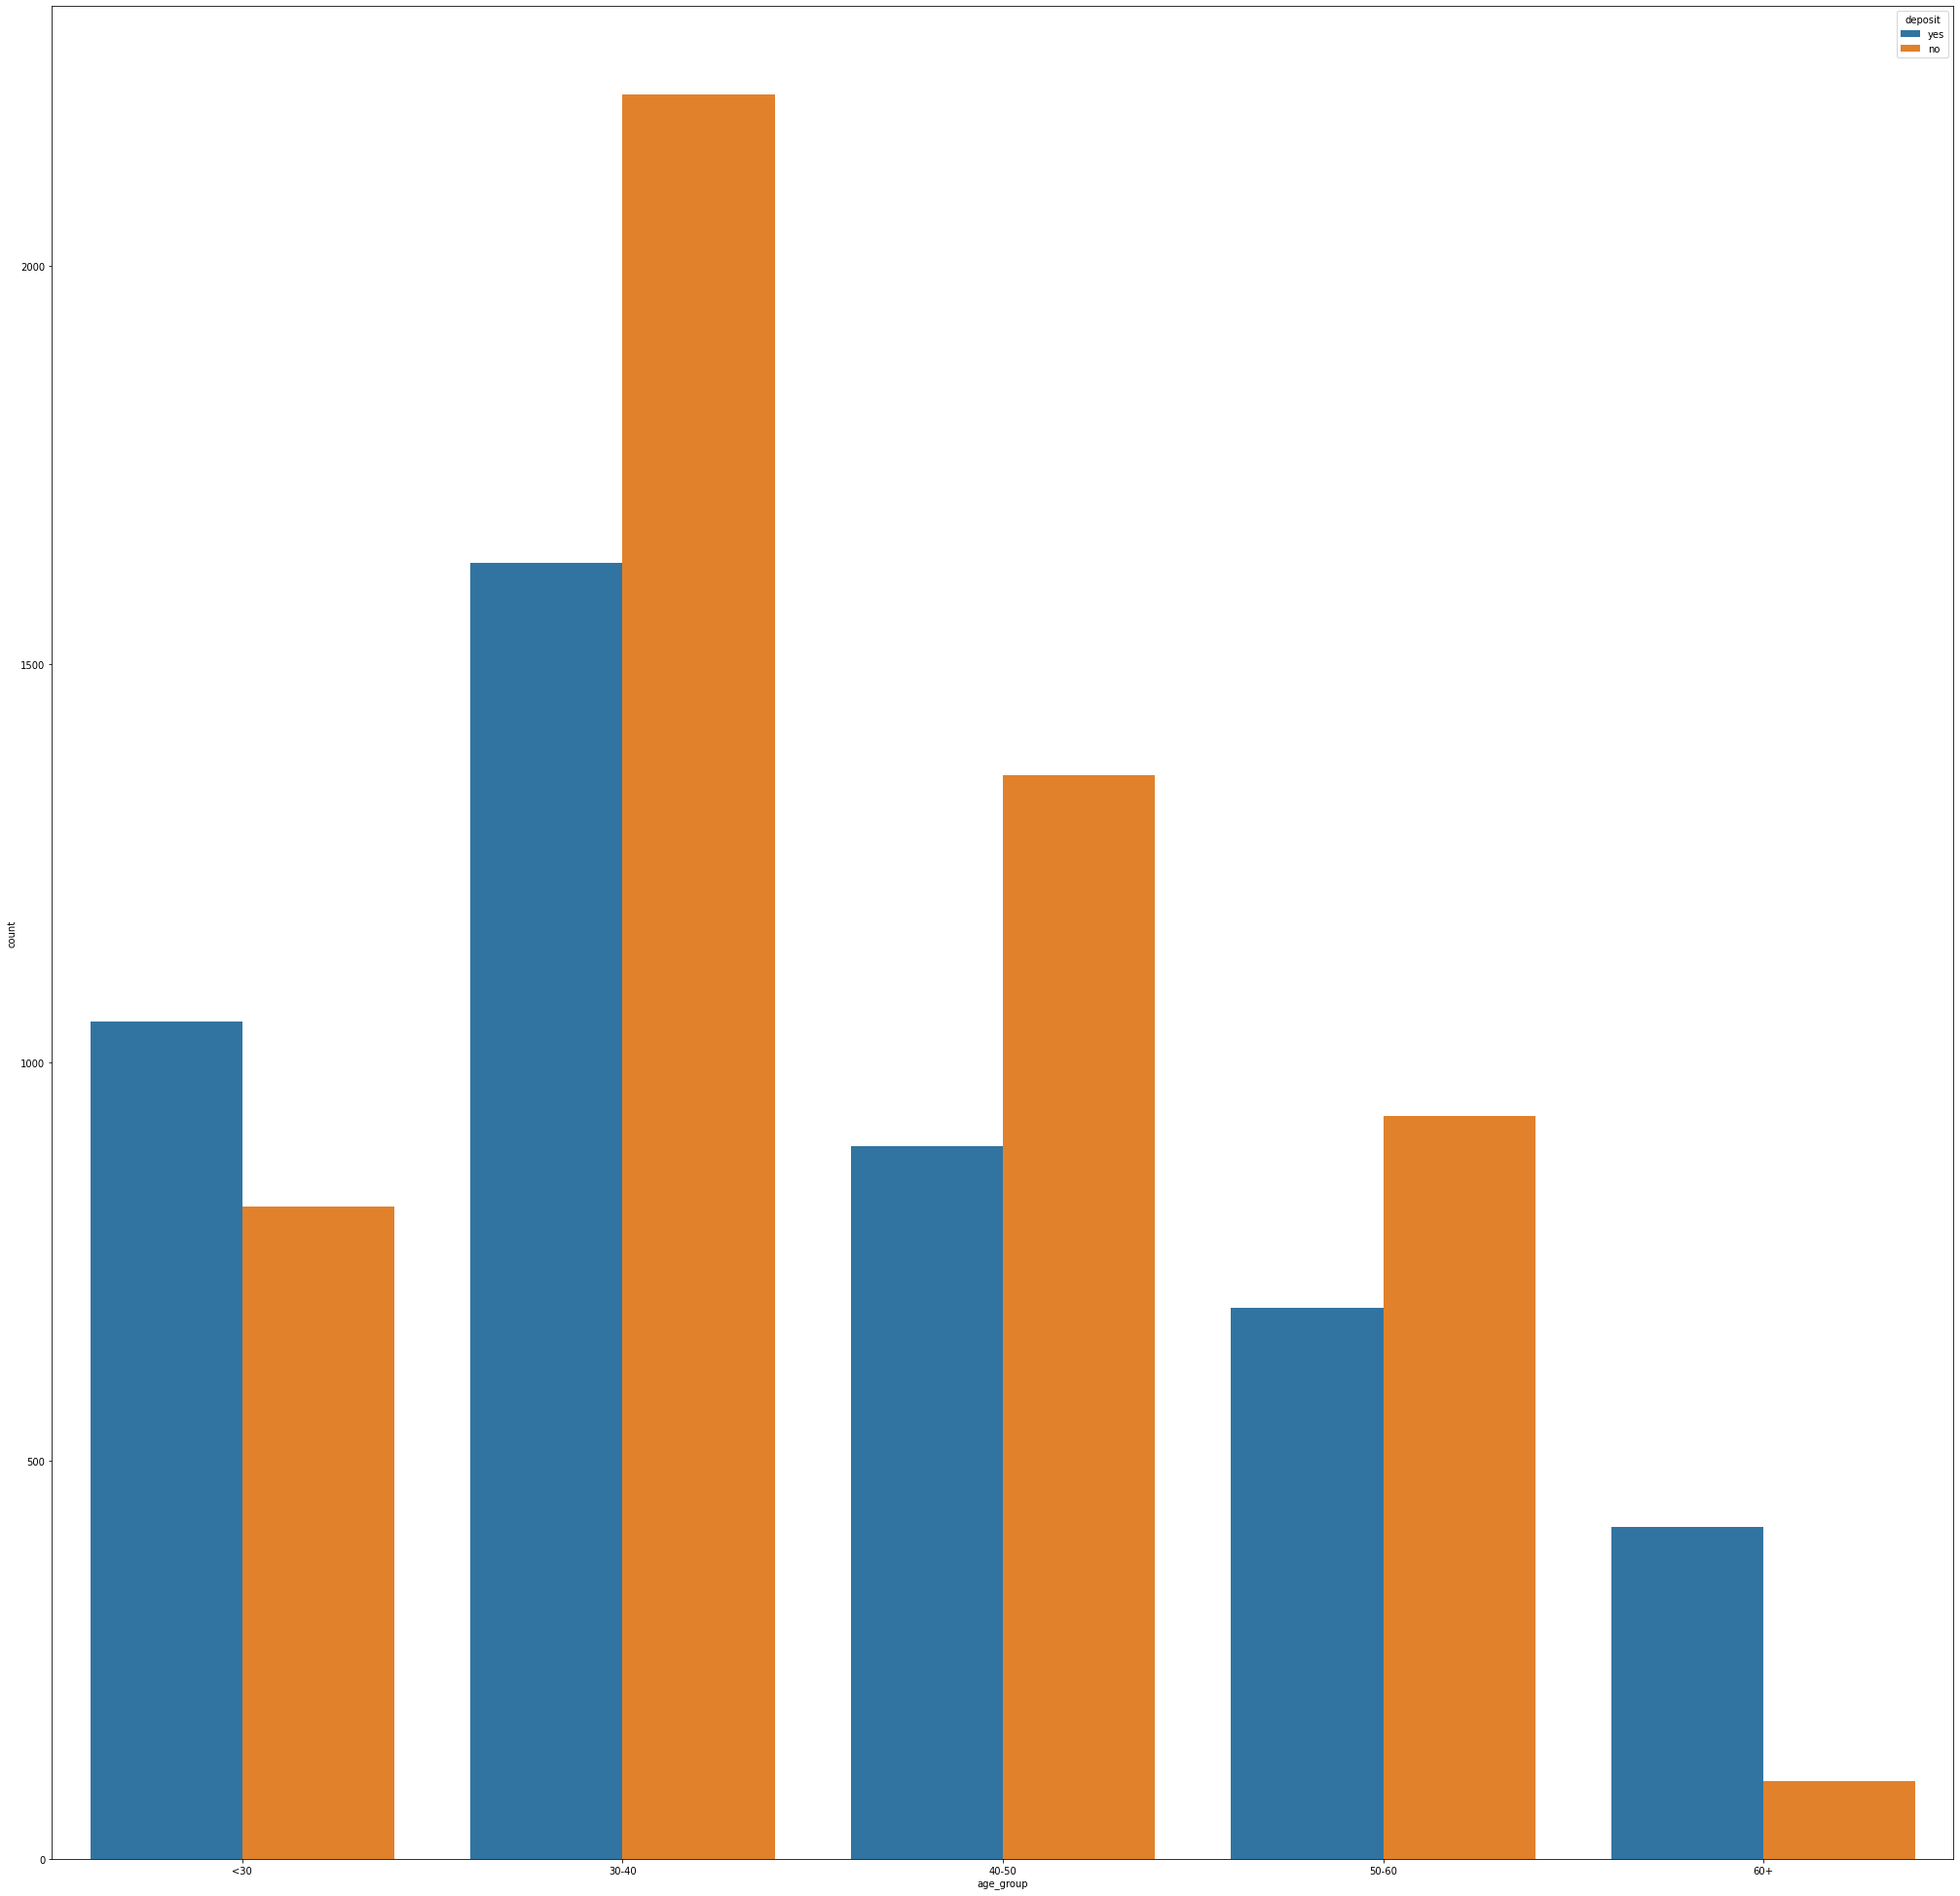

In [287]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

cleaned['age_group'] = pd.cut(cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=cleaned)

### Задания 9 и 10

<AxesSubplot: xlabel='count', ylabel='marital'>

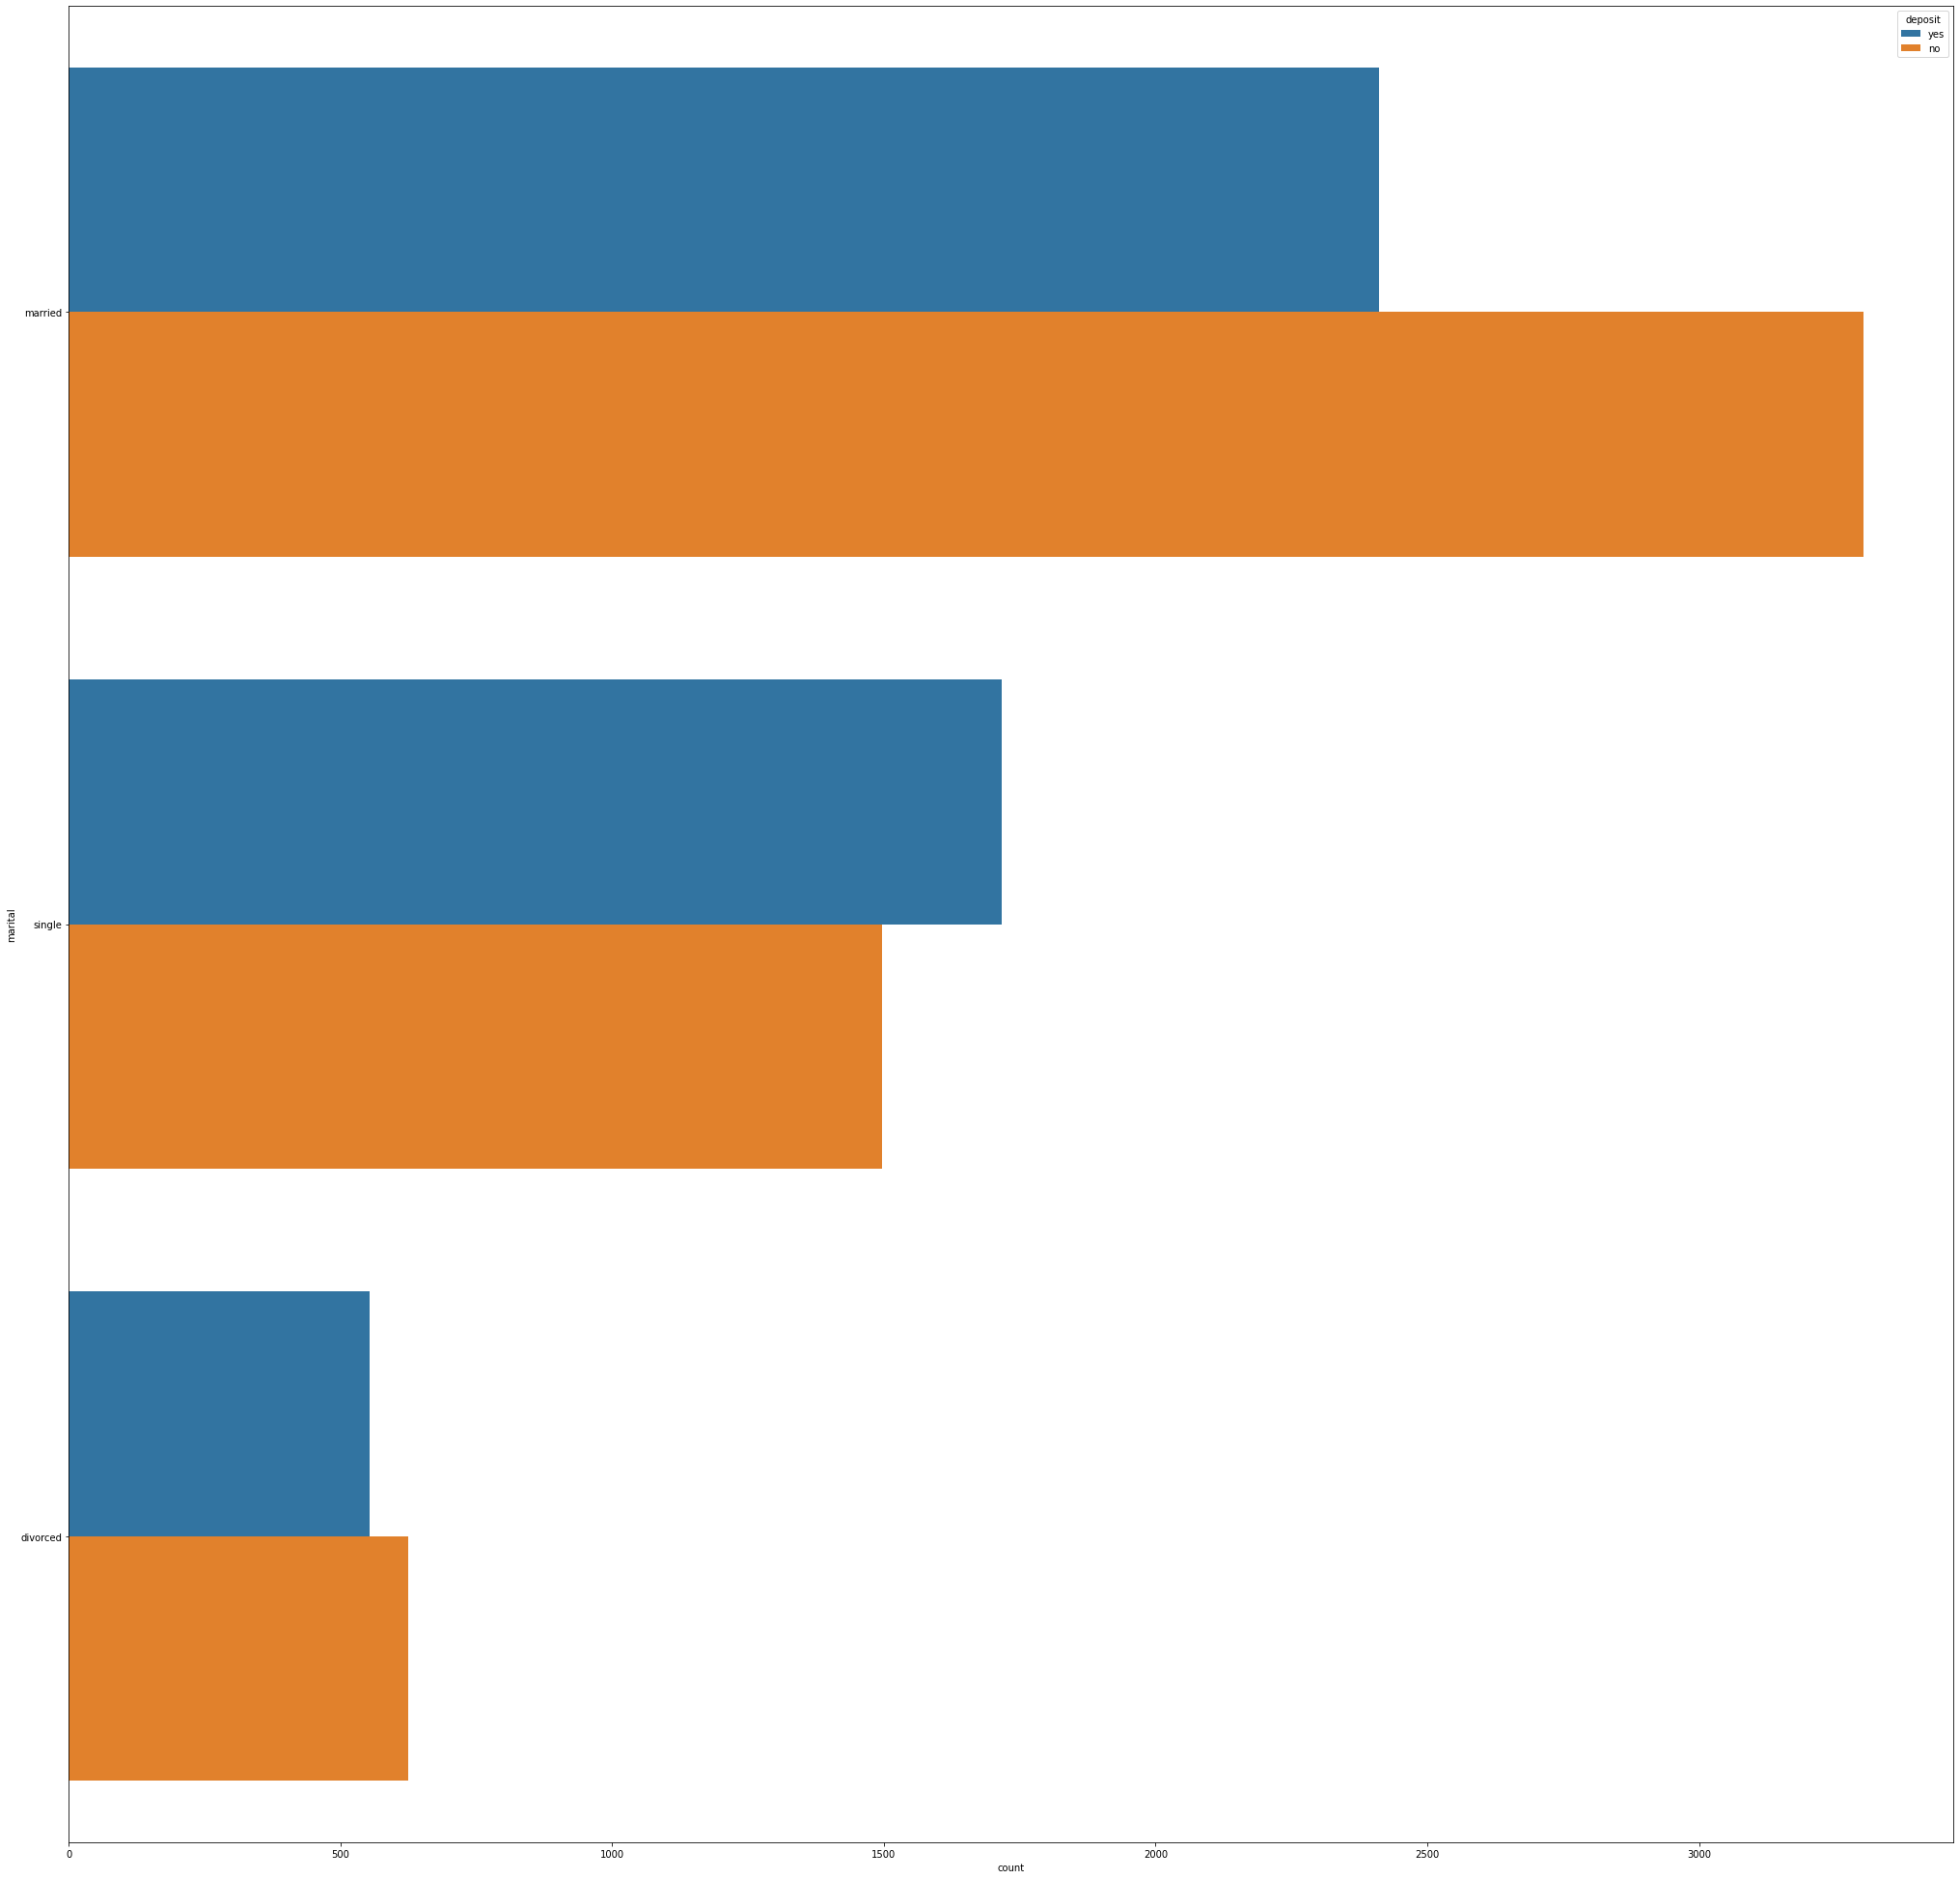

In [288]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=cleaned)

<AxesSubplot: xlabel='count', ylabel='education'>

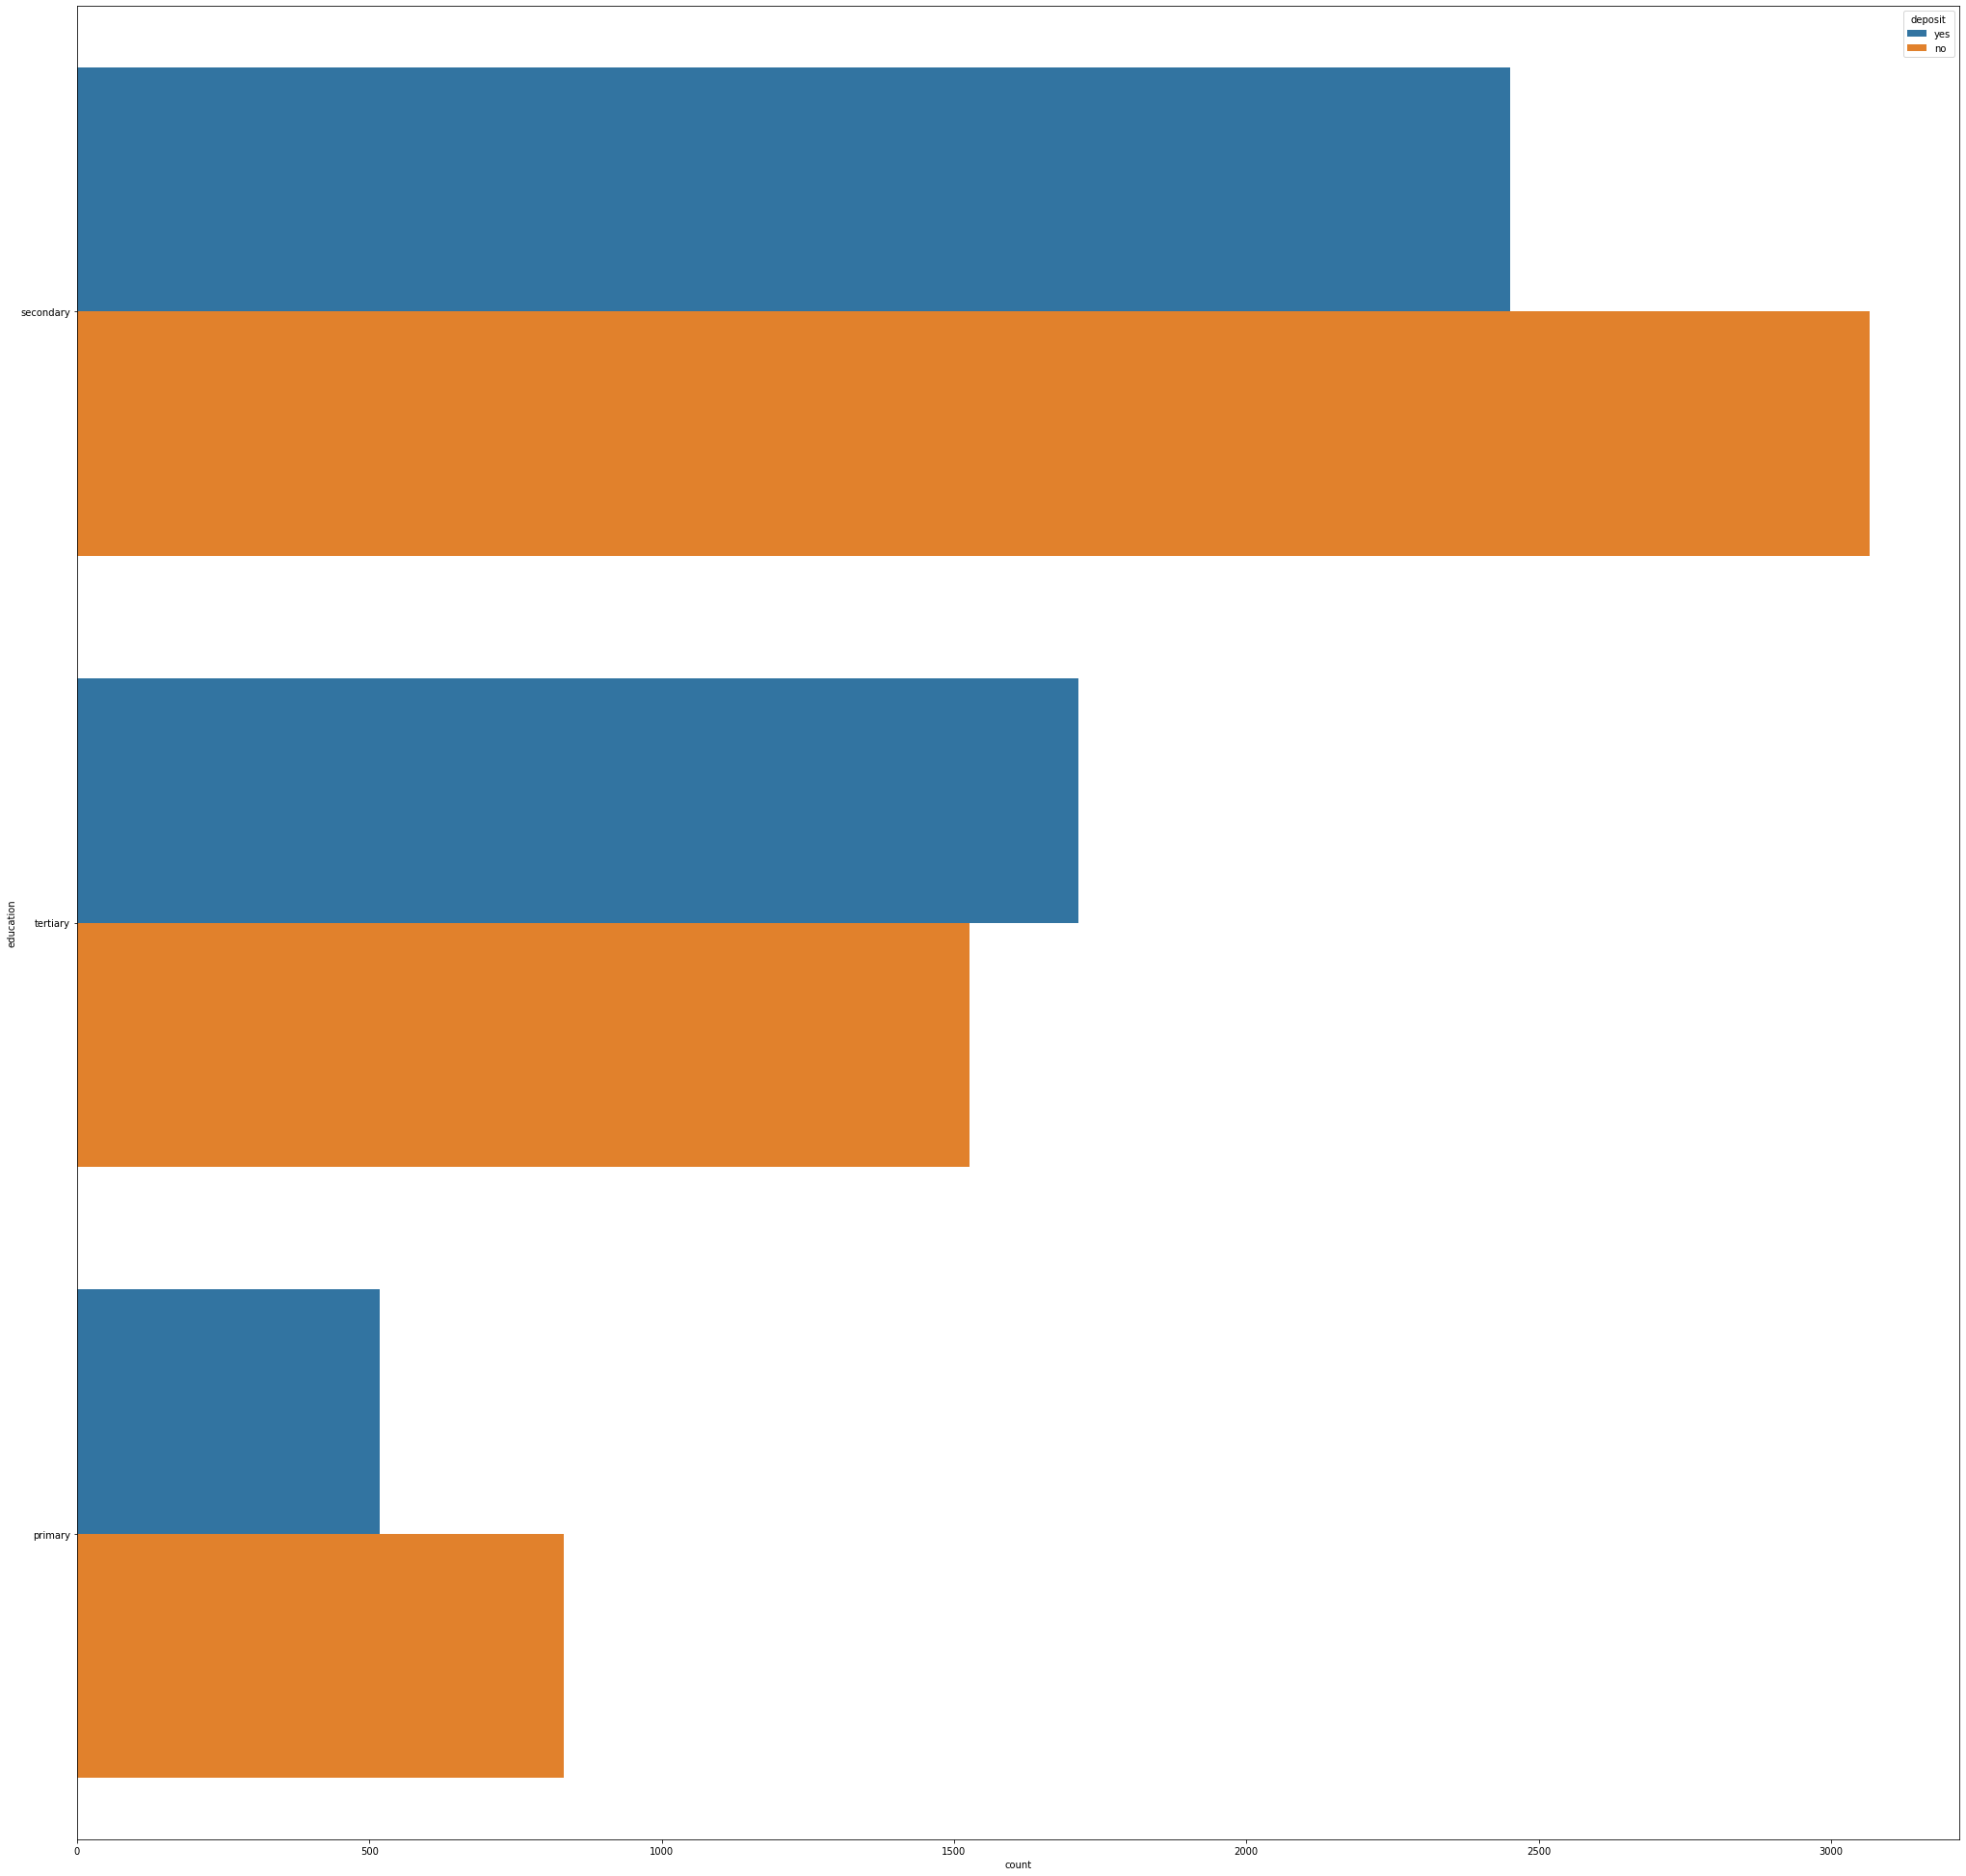

In [289]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=cleaned)

<AxesSubplot: xlabel='count', ylabel='job'>

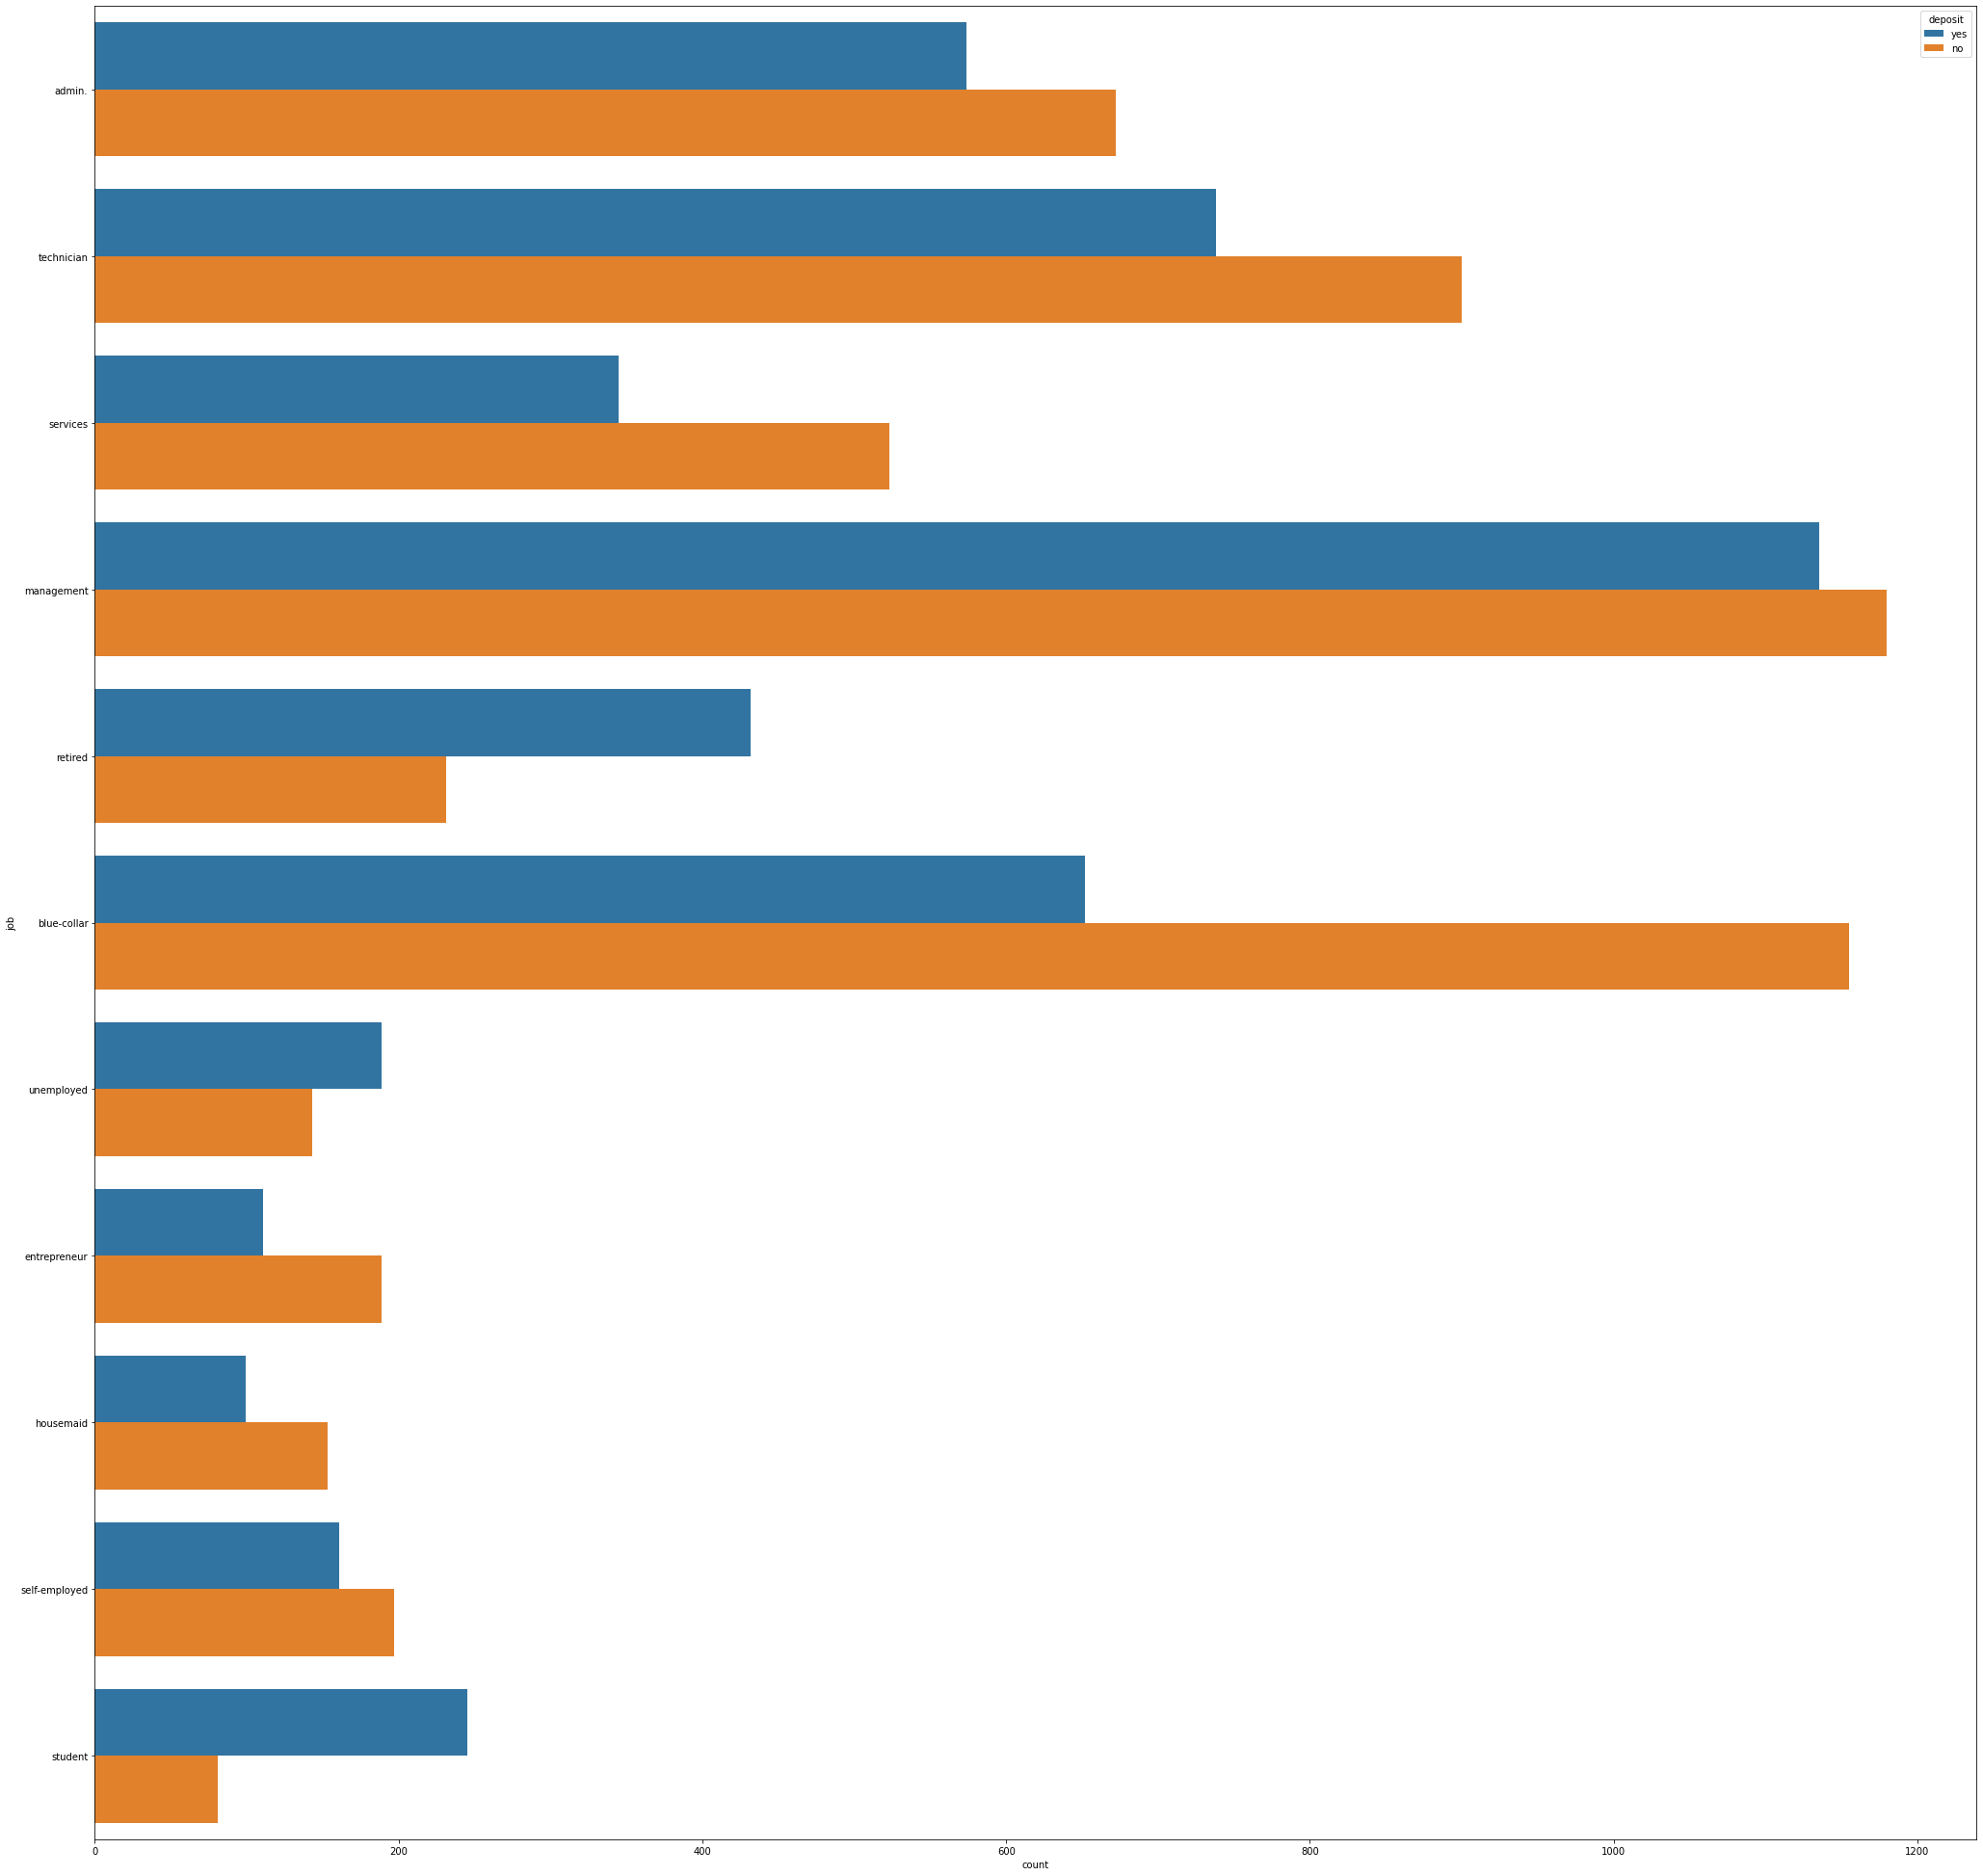

In [290]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=cleaned)

### Задание 11

<AxesSubplot: xlabel='education', ylabel='deposit'>

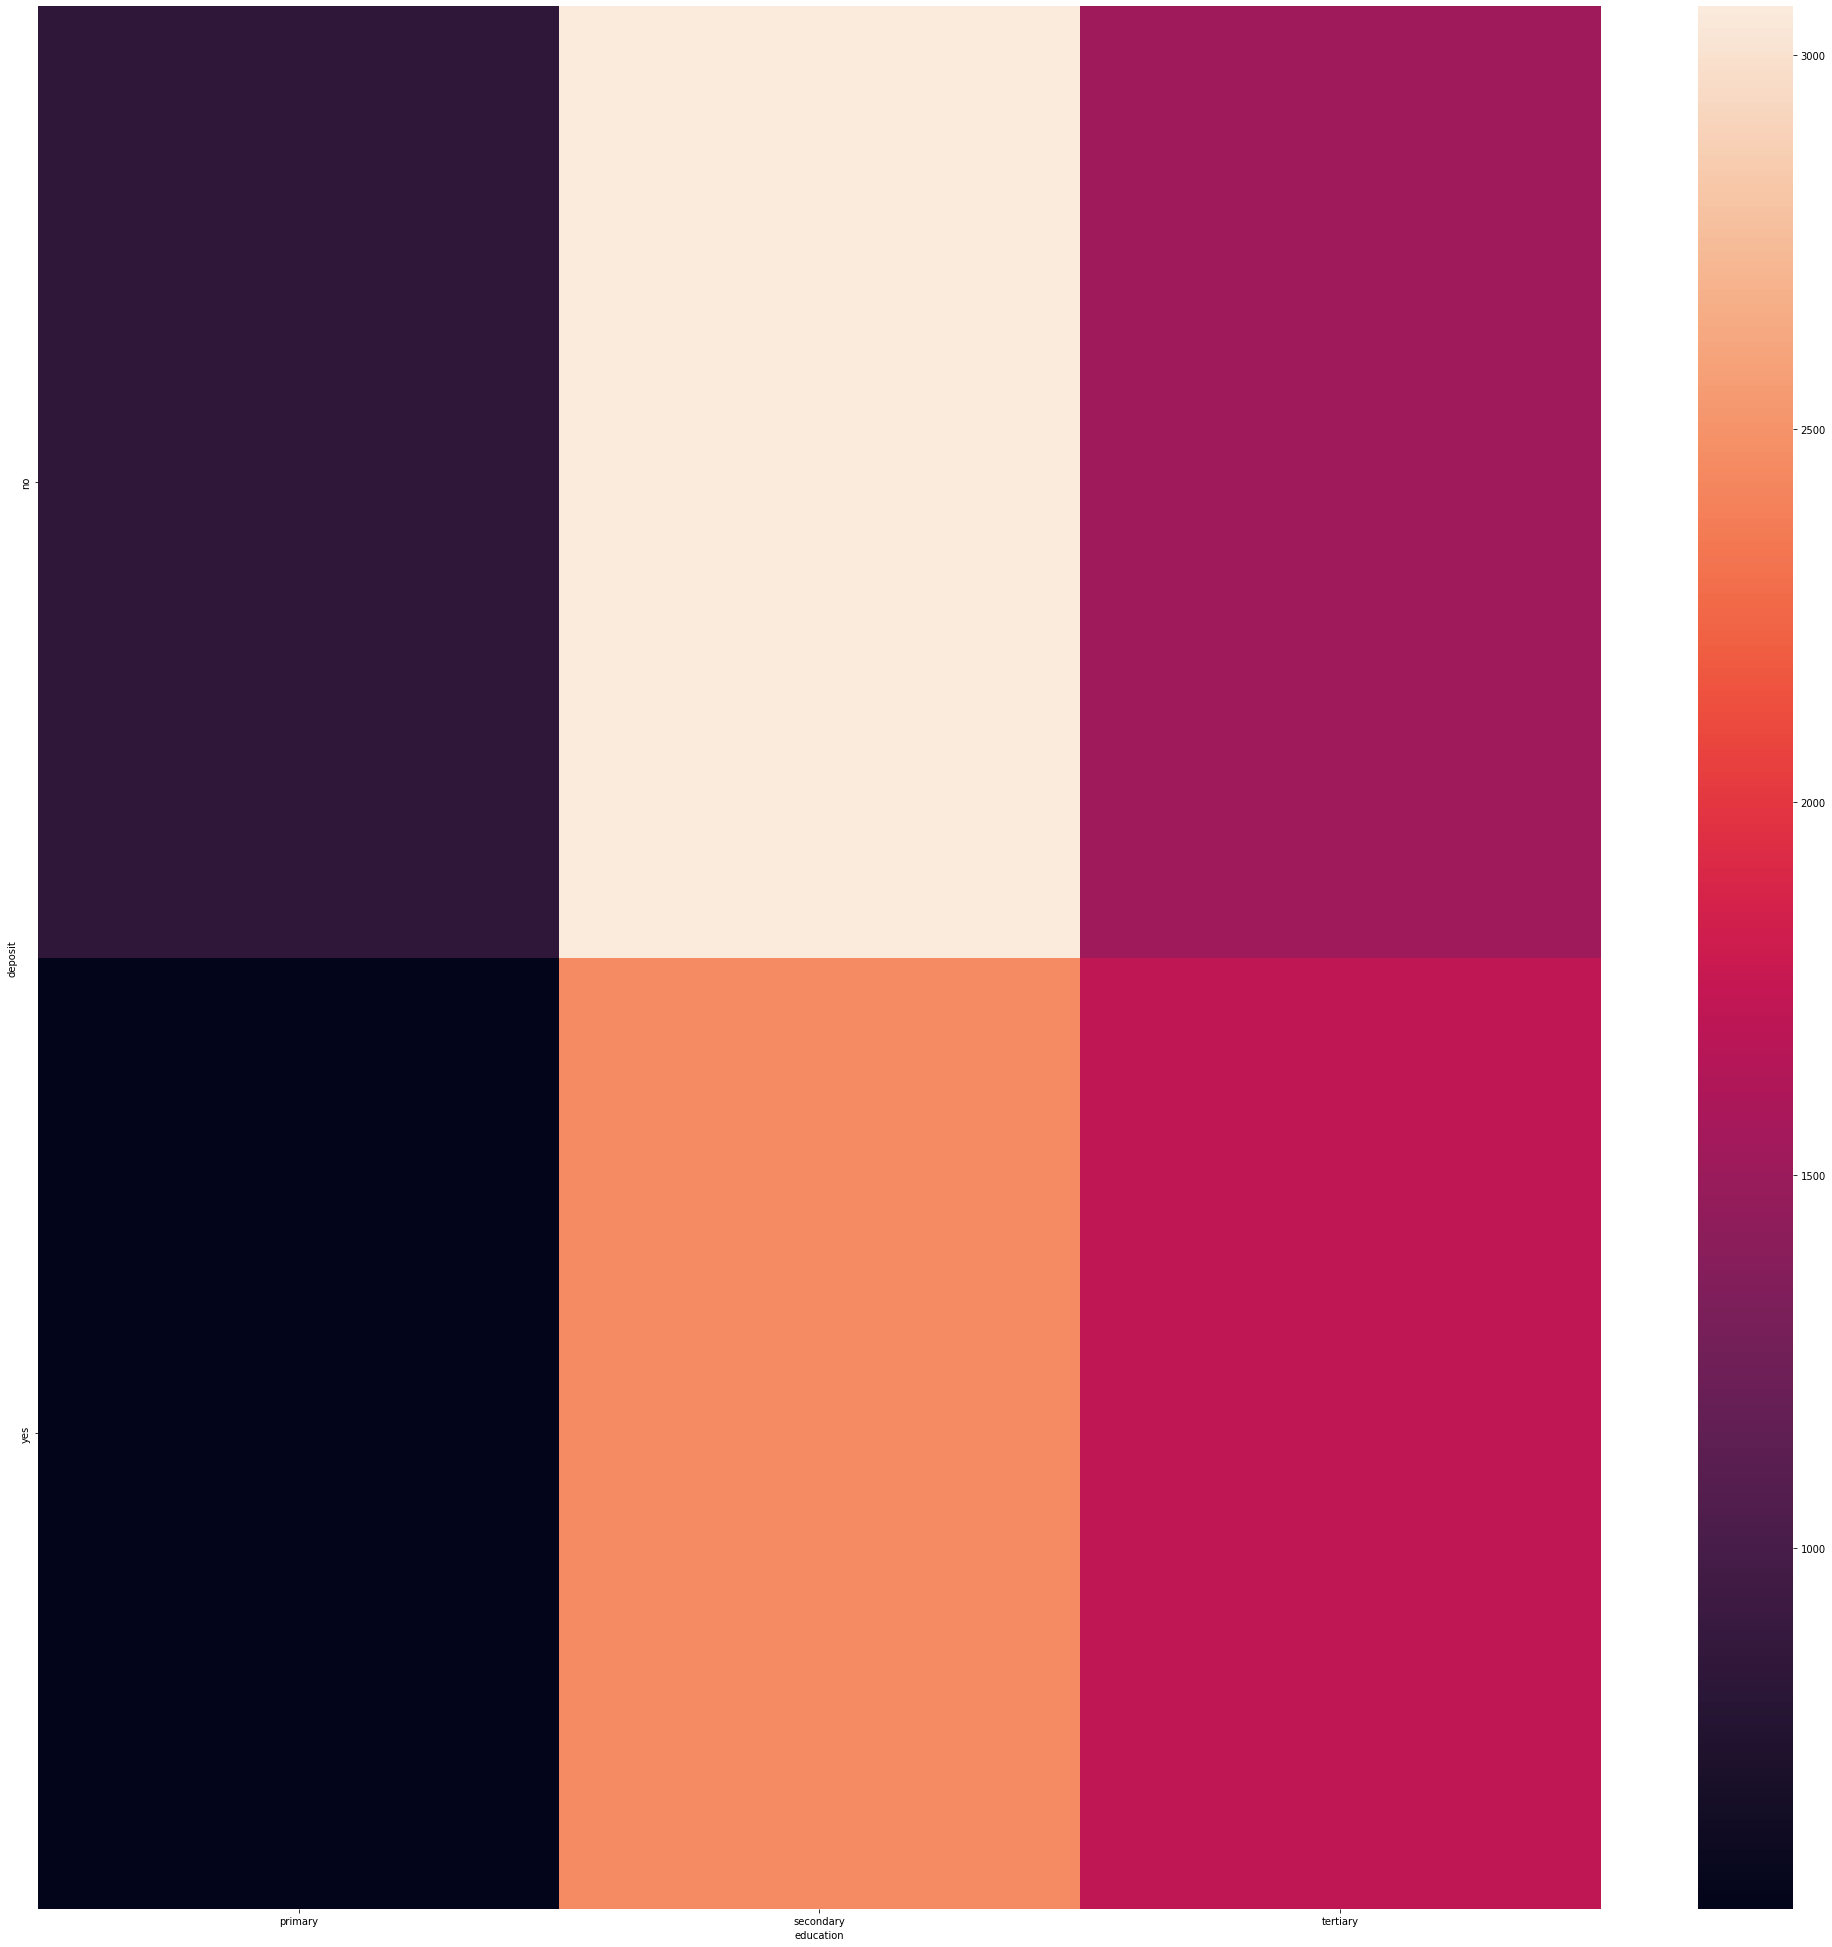

In [291]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
sns.heatmap(pd.crosstab(cleaned.deposit,cleaned.education)) 

<AxesSubplot: xlabel='marital', ylabel='deposit'>

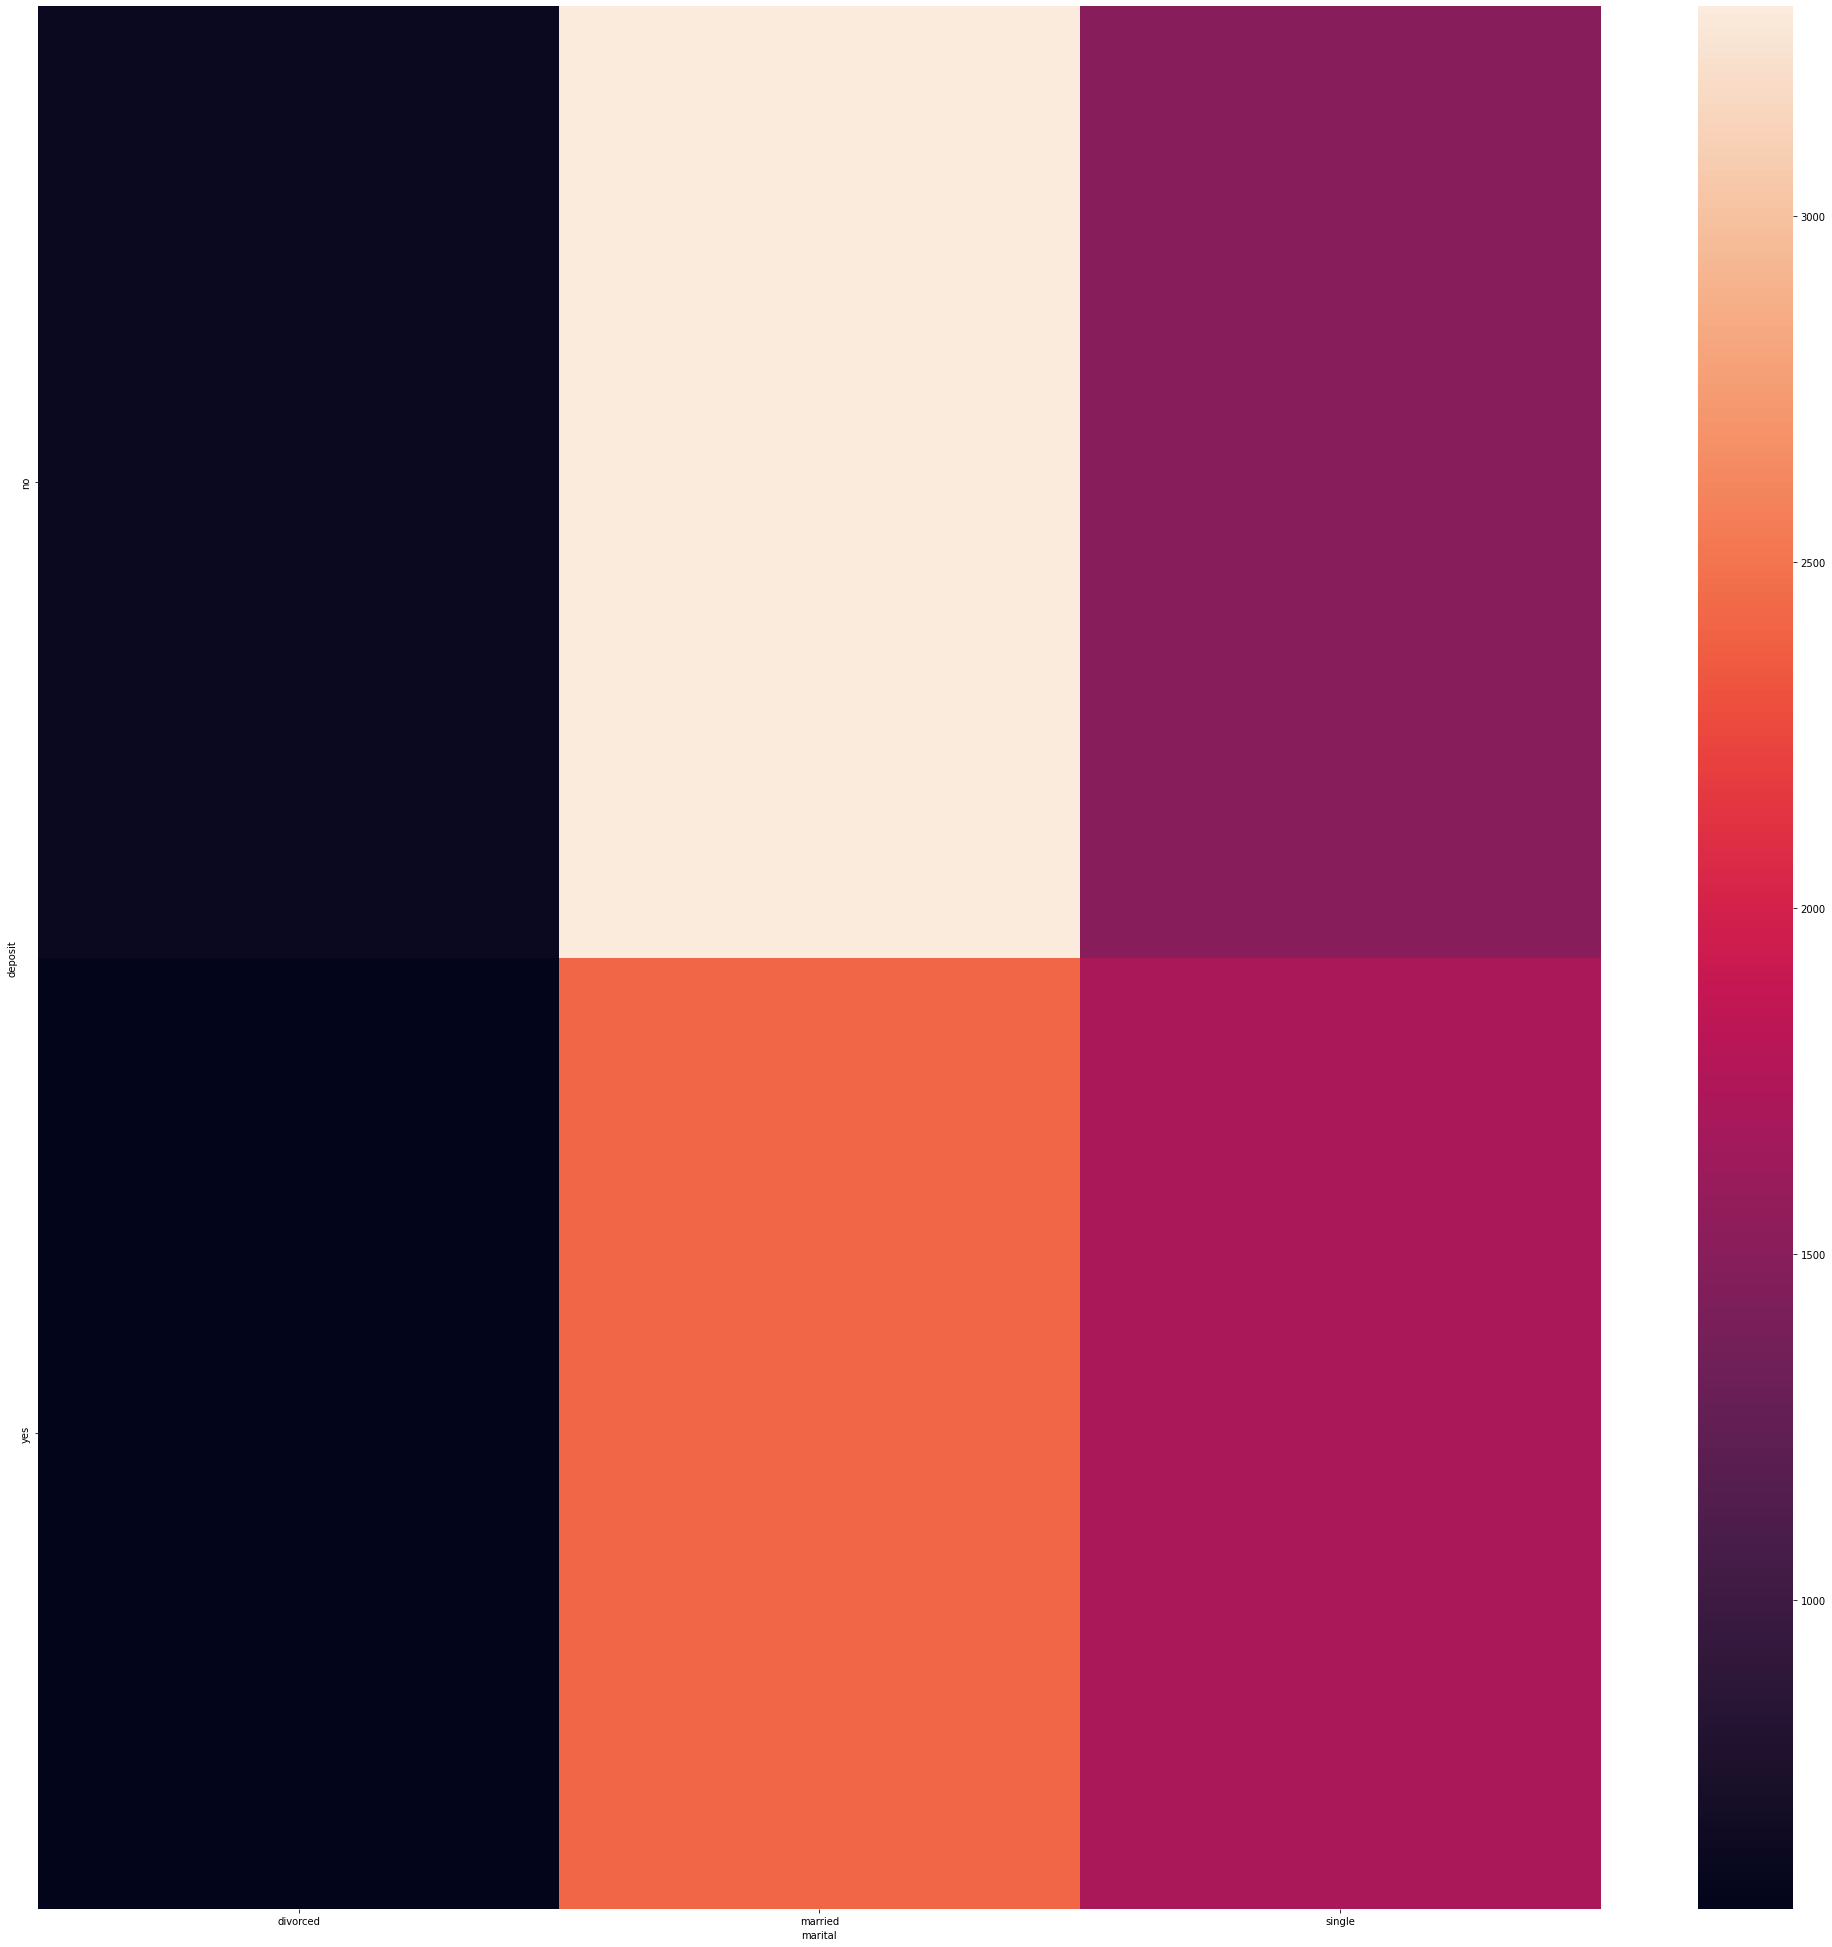

In [292]:
sns.heatmap(pd.crosstab(cleaned.deposit,cleaned.marital))

## Часть 3: преобразование данных

### Задание 1

In [293]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
cleaned['education'] = lab_enc.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

### Задания 2 и 3

In [294]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['deposit']=cleaned['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

In [295]:
cleaned['deposit'].std()

0.4986712532452124

In [296]:
cleaned['default']=cleaned['default'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['housing']=cleaned['housing'].apply(lambda x: 1 if x == 'yes' else 0)
cleaned['loan']=cleaned['loan'].apply(lambda x: 1 if x == 'yes' else 0)


In [297]:
print(cleaned['default'].mean() + cleaned['housing'].mean()+cleaned['loan'].mean())

0.6354280059376547


In [298]:
cleaned.shape

(10105, 18)

In [299]:
cleaned['poutcome'].nunique()

4

### Задание 4

In [300]:
# создайте дамми-переменные
col_dum=['job','marital','contact','month','poutcome']
cleaned=pd.get_dummies(cleaned, columns=col_dum)


In [301]:
cleaned.shape

(10105, 46)

### Задания 5 и 6

<AxesSubplot: >

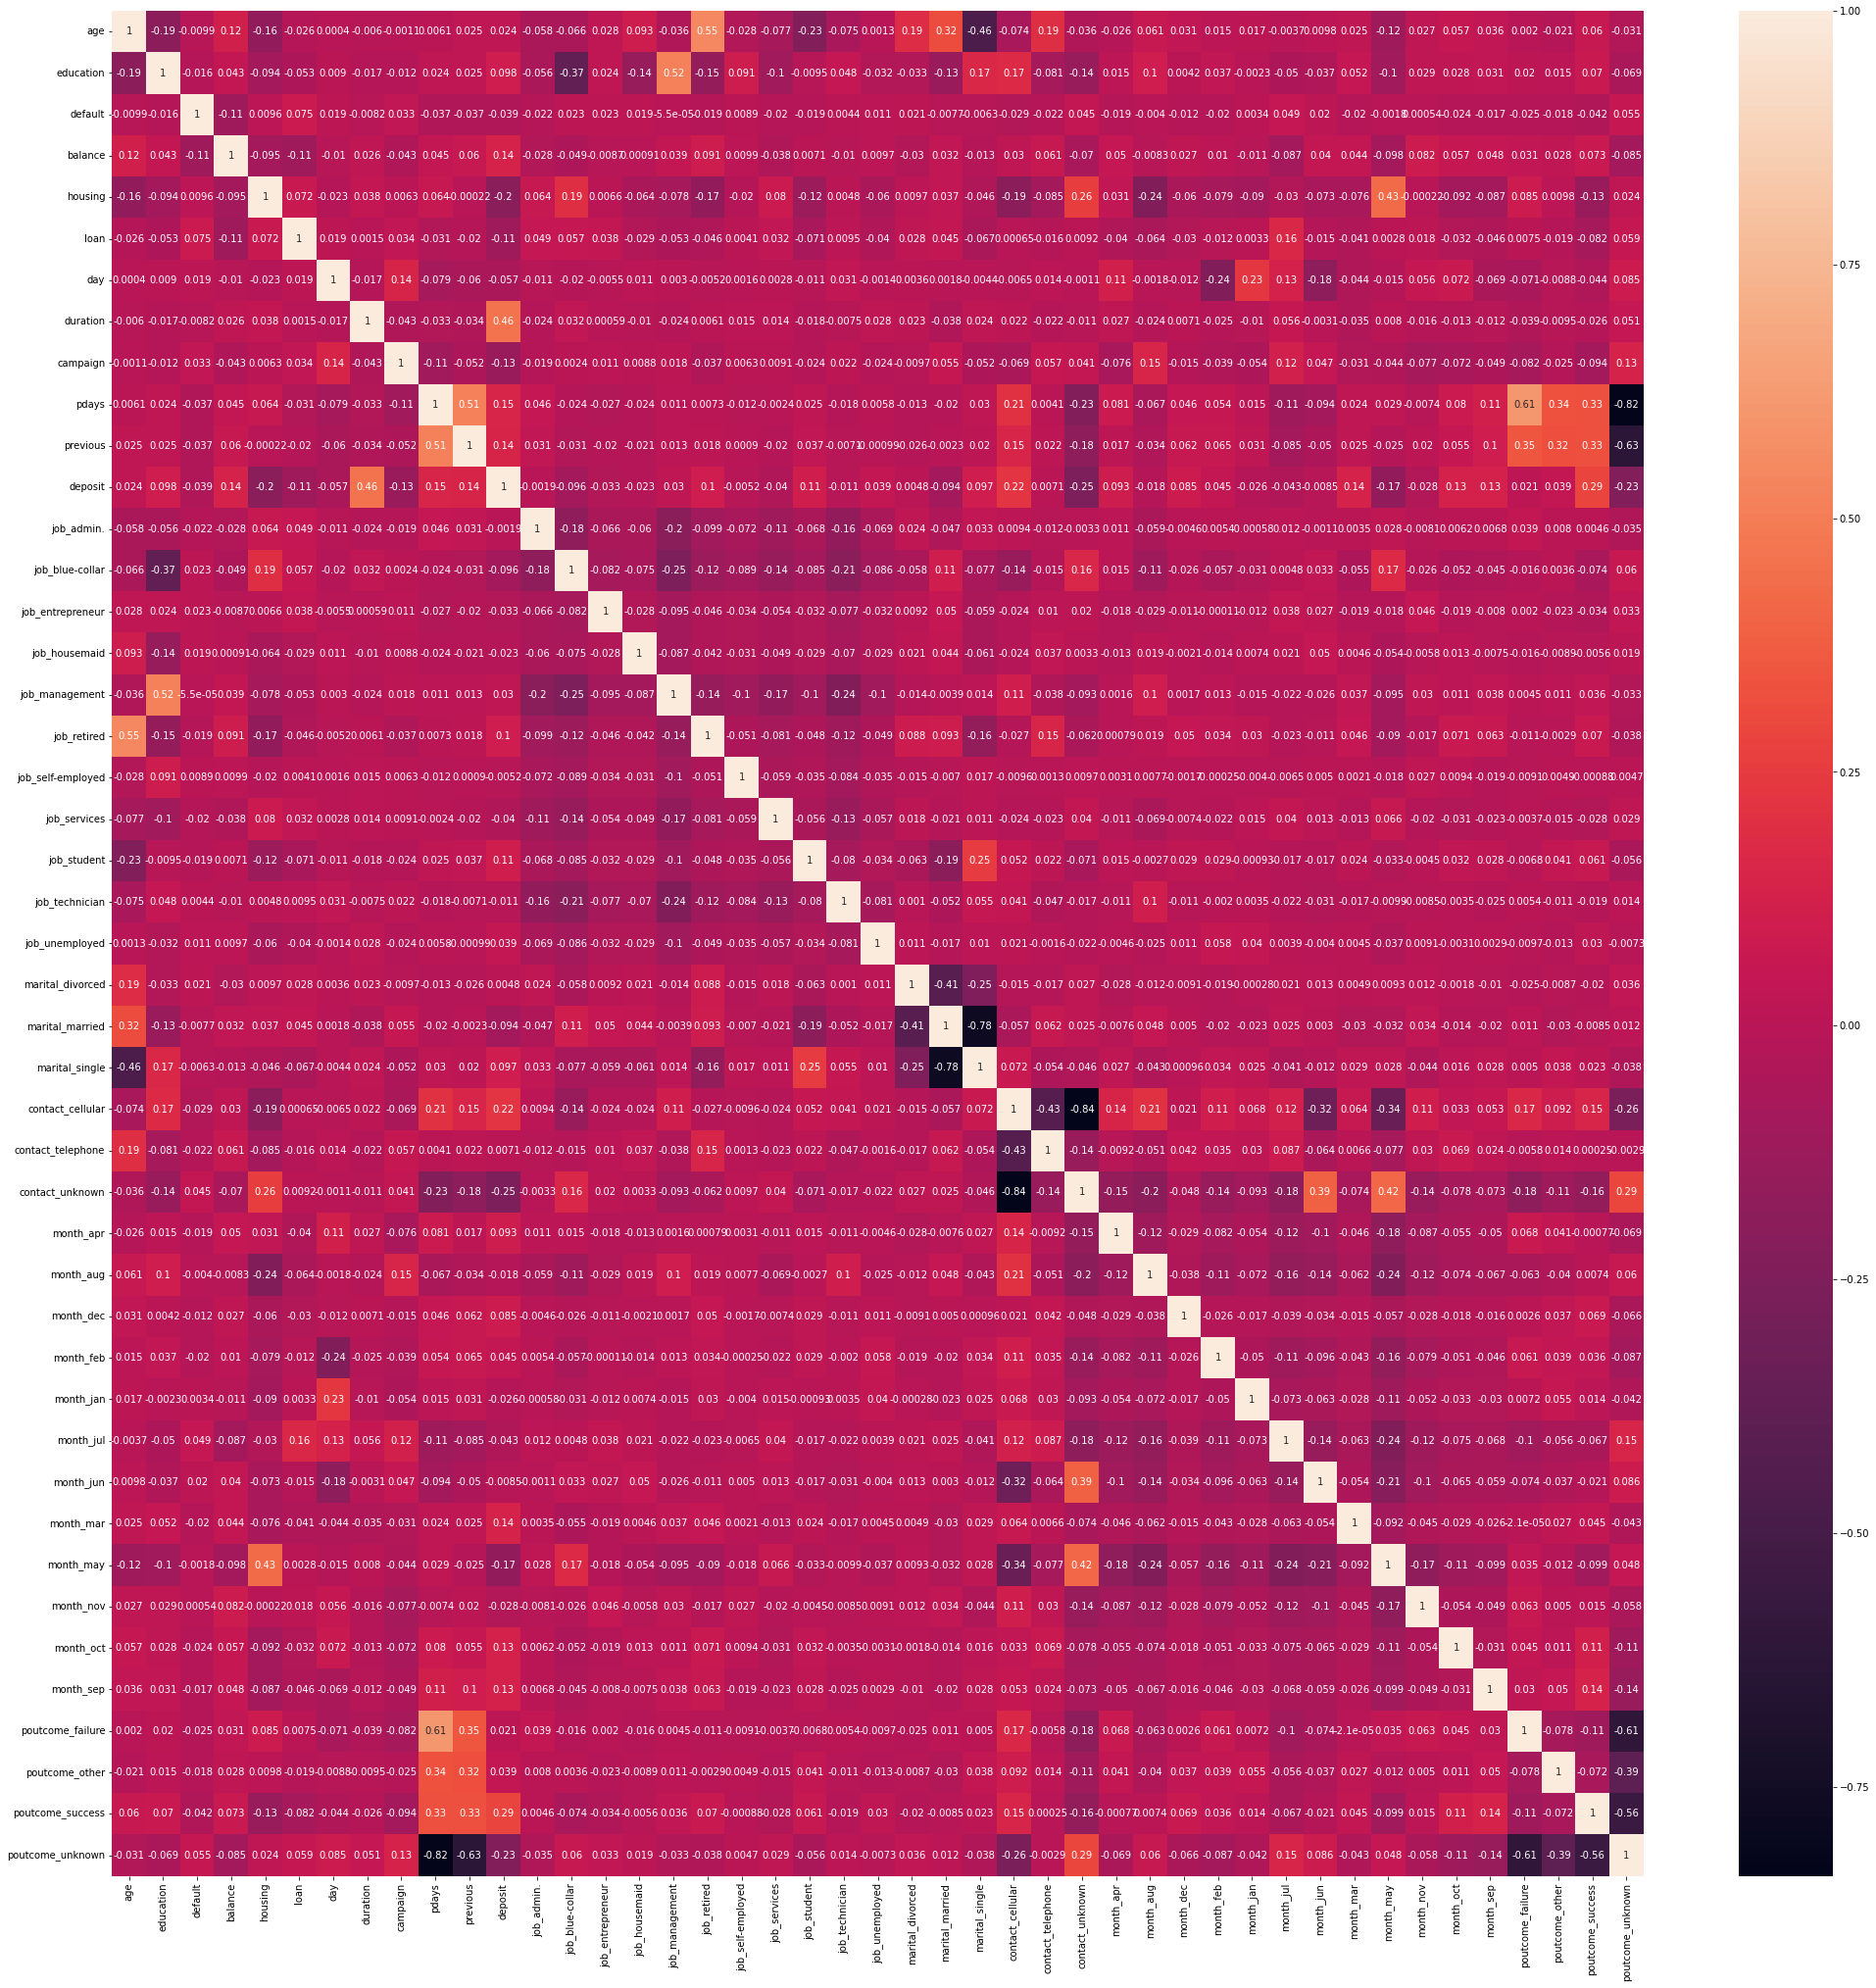

In [302]:
plt.rcParams['figure.figsize'] = (35,35)
sns.heatmap(cleaned.corr(), annot=True)

In [303]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

NameError: name 'corr' is not defined

### Задания 7 и 8

In [310]:
cleaned['age_group'] = lab_enc.fit_transform(cleaned['age_group'])

In [333]:
X = cleaned.drop(['deposit'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [334]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [335]:
y_test.mean()

0.46326836581709147

### Задание 9

In [336]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6770 entries, 7287 to 4966
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6770 non-null   int64  
 1   education          6770 non-null   int64  
 2   default            6770 non-null   int64  
 3   balance            6770 non-null   float64
 4   housing            6770 non-null   int64  
 5   loan               6770 non-null   int64  
 6   day                6770 non-null   int64  
 7   duration           6770 non-null   int64  
 8   campaign           6770 non-null   int64  
 9   pdays              6770 non-null   int64  
 10  previous           6770 non-null   int64  
 11  age_group          6770 non-null   int64  
 12  job_admin.         6770 non-null   uint8  
 13  job_blue-collar    6770 non-null   uint8  
 14  job_entrepreneur   6770 non-null   uint8  
 15  job_housemaid      6770 non-null   uint8  
 16  job_management     67

In [337]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train,y_train)
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [338]:

X_train=selector.transform(X_train)
X_test=selector.transform(X_test)

### Задание 10

In [339]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train)    # fransform() на train данных
X_test_scaled = scaler.transform(X_test)      # fransform() на test данных

print(X_test_scaled[:, 0].mean())  # для признака balance, обратите внимание именно на столбец

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [340]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

y_train_pred=log_reg.predict(X_train_scaled)
y_test_pred=log_reg.predict(X_test_scaled)

print(f'Accuracy score for train:{round(metrics.accuracy_score(y_train_pred,y_train),2)}')
print(f'Accuracy score for test:{round(metrics.accuracy_score(y_test_pred,y_test),2)}')

Accuracy score for train:0.82
Accuracy score for test:0.81


### Задания 2,3,4

In [361]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

y_train_pred=dt.predict(X_train_scaled)
y_test_pred=dt.predict(X_test_scaled)

print(f'Accuracy score for train:{round(metrics.accuracy_score(y_train_pred,y_train),2)}')
print(f'Accuracy score for test:{round(metrics.accuracy_score(y_test_pred,y_test),2)}')

Accuracy score for train:0.82
Accuracy score for test:0.81


### Задание 5

In [365]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

In [369]:
print("accuracy на обучающем наборе: {:.2f}".format(model_cv.score(X_train_scaled, y_train)))
y_train_pred = model_cv.predict(X_train_scaled)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

print("accuracy на тестовом наборе: {:.2f}".format(model_cv.score(X_test_scaled, y_test)))
y_test_pred = model_cv.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

accuracy на обучающем наборе: 0.83
f1_score на обучающем наборе: 0.83
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [370]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [384]:
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.817


### Задания 2 и 3

In [373]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [385]:
y_test_pred = gb.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

f1_score на тестовом наборе: 0.816


### Задание 4

In [386]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [389]:
y_test_pred = stack.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335

f1_score на тестовом наборе: 0.810


### Задание 5

In [400]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE

estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_scaled, y_train)
selector.get_feature_names_out()
#X_train.columns
selector.ranking_

array([ 6,  3,  1,  9,  2, 12,  4, 13,  1,  5, 11,  7,  8,  1, 10])

In [401]:
selector.get_feature_names_out()

array(['x2', 'x8', 'x13'], dtype=object)

In [404]:
selector.support_

array([False, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True, False])

In [426]:
print(selector.get_feature_names_out())
print(X.columns)
selector.ranking_

['x2' 'x8' 'x13']
Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'age_group', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 6,  3,  1,  9,  2, 12,  4, 13,  1,  5, 11,  7,  8,  1, 10])

### Задания 6,7,8

In [415]:
import optuna

In [419]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
  max_depth = trial.suggest_int('max_depth', 10, 30, 1);
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1);

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [420]:
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-02-27 15:46:58,233] A new study created in memory with name: RandomForestClassifier
[I 2023-02-27 15:46:59,697] Trial 0 finished with value: 0.842039018250472 and parameters: {'n_estimators': 183, 'max_depth': 10, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.842039018250472.
[I 2023-02-27 15:47:01,014] Trial 1 finished with value: 0.8800250273736899 and parameters: {'n_estimators': 149, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8800250273736899.
[I 2023-02-27 15:47:01,939] Trial 2 finished with value: 0.865177316044368 and parameters: {'n_estimators': 164, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8800250273736899.
[I 2023-02-27 15:47:02,479] Trial 3 finished with value: 0.8425023577491354 and parameters: {'n_estimators': 107, 'max_depth': 13, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8800250273736899.
[I 2023-02-27 15:47:03,358] Trial 4 finished with value: 0.8453316567117259 and parameters: {'n_e

In [423]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


In [427]:
y_1 = [1.23, 2.35, 2.75]
y_2= [1.01, 12.3, 2.74]

In [428]:
#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
sqrt(mean_squared_error(y_1, y_2)) 

5.746042116100439